In [37]:
import os 
import h5py
import glob
import numpy as np
from openbabel import openbabel as ob 
import torch
import ase
from ase.io import read, write
from ase.calculators.orca import ORCA
from ase.calculators.orca import OrcaProfile
from ase import Atoms
from openbabel import pybel
import requests
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import shutil
from rdkit.Chem import rdmolops
from tqdm import tqdm
import subprocess
from mace.calculators import mace_off
from numpy import printoptions

 
# filename='/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_b973c_ens.jpt'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = torch.jit.load(filename, map_location=device)

hartree2ev = 27.211386245988
ev2hartree = 1/hartree2ev
ev2kcalmol = 23.0605

np.set_printoptions(precision=10)
torch.set_printoptions(precision=10)
from matplotlib import rcParams
import numpy as np
import pandas as pd
# rcParams['font.family'] = 'serif'

rcParams['font.family'] = "sans-serif"
rcParams['font.size'] = 10
rcParams["figure.figsize"] = [3, 3]
rcParams["figure.dpi"] = 150.0

In [7]:
import os 

os.chdir("/mnt/c/Users/user/Downloads/orca_sp_large_systems/orca_sp_large_systems/cdk2_22/temp")

In [2]:
##AIMNET2-NSE

filename='/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_ens.jpt'
model_path='/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_ens.jpt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.jit.load(filename, map_location=device)

In [3]:
def save_xyz_file_complex(coord_ALAs, number_ALAs, save_filename):

    # Dictionary to map atomic numbers to element symbols
    atomic_number_to_symbol = {1: 'H',5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F',
                                     14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 
                                     33: 'As', 34: 'Se', 35: 'Br', 53: 'I'}

    # Conversion factor from Bohr to Angstrom
    bohr_to_angstrom = 0.529177249

    # Convert coordinates from Bohr to Angstrom
    coord_ALAs_ang = coord_ALAs * bohr_to_angstrom

    # Number of atoms
    num_atoms = len(coord_ALAs_ang)
    
    base_name = os.path.splitext(os.path.basename(save_filename))[0]

    # Creating the XYZ format content
    xyz_content = f"{num_atoms}\n"
    xyz_content += f"{base_name}\n"


    # Adding atomic symbols and coordinates to the XYZ content
    for num, coord in zip(number_ALAs, coord_ALAs_ang):
        element_symbol = atomic_number_to_symbol[num]
        xyz_content += f"{element_symbol} {coord[0]:.10f} {coord[1]:.10f} {coord[2]:.10f}\n"

    # Writing to an XYZ file
    with open(save_filename, "w") as xyz_file:
        xyz_file.write(xyz_content)
        

def explore_hdf5_file(file_path, max_examples=5):
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Print the root directory
        print(f"Root directory: {file_path}")
        print("")

        # Function to explore groups and print examples
        def explore_groups(group, indent=0, examples_limit=5):
            group_count = 0
            examples_printed = 0

            # Collect group keys
            group_keys = list(group.keys())
            print(f"{'  ' * indent}Total groups: {len(group_keys)}")
            print(f"{'  ' * indent}Group names: {', '.join(group_keys)}")
            print("")

            # Explore and print example groups
            for key in group_keys:
                if examples_printed >= examples_limit:
                    break
                
                item = group[key]
                if isinstance(item, h5py.Group):
                    print(f"{'  ' * indent}Group: {key}/")
                    explore_groups(item, indent + 1, examples_limit - examples_printed)
                    examples_printed += 1
                    group_count += 1
                elif isinstance(item, h5py.Dataset):
                    shape = item.shape
                    size = item.size
                    print(f"{'  ' * indent}Dataset: {key} (size: {size}, shape: {shape})")
                    
                    # Calculate and print the number of conformations if shape is known
                    if shape and len(shape) == 3 and shape[1] == 3:
                        num_conformations = size // (shape[0] * shape[1])
                        print(f"{'  ' * (indent + 1)}Number of conformations: {num_conformations}")

            return group_count

        # Start exploring from root
        total_groups = explore_groups(f, examples_limit=max_examples)
        print(f"Total number of groups: {total_groups}")
        
def read_smiles_from_group(file_path, group_name, dataset_name):
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Navigate to the specified group
        group = f[group_name]
        
        # Read the specified dataset within the group
        dataset = group[dataset_name]
        # dataset2= group[dataset_name2]
        
        # Get the data from the dataset
        smiles_data = dataset[()]
        # smiles_data2=dataset2[()]
        
        return smiles_data
    
def compute_mace(mol_path,ev2hartree=ev2hartree):
    molecule = read(mol_path)
    calc = mace_off(model="large", device='cuda',default_dtype="float64")

    molecule.calc = calc
    return(molecule.get_potential_energy()*ev2hartree)


def read_xyz_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    atoms = []
    for line in lines[2:]:
        parts = line.split()
        if len(parts) == 4:
            atom_type = parts[0]
            # Round the coordinates to 5 decimal places
            # x, y, z = [round(float(coord), 3) for coord in parts[1:]]
            x, y, z = [float(f"{float(coord):.2f}") for coord in parts[1:]]
            atoms.append((atom_type, (x, y, z)))
    return atoms


def save_xyz_file(coord_ALAs, number_ALAs, save_filename):

    # Dictionary to map atomic numbers to element symbols
    atomic_number_to_symbol = {1: 'H',5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F',
                                     14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 
                                     33: 'As', 34: 'Se', 35: 'Br', 53: 'I'}

    # Number of atoms
    num_atoms = len(coord_ALAs)
    
    base_name = os.path.splitext(os.path.basename(save_filename))[0]

    # Creating the XYZ format content
    xyz_content = f"{num_atoms}\n"
    xyz_content += f"{base_name}\n"


    # Adding atomic symbols and coordinates to the XYZ content
    for num, coord in zip(number_ALAs, coord_ALAs):
        element_symbol = atomic_number_to_symbol[num]
        xyz_content += f"{element_symbol} {coord[0]:.10f} {coord[1]:.10f} {coord[2]:.10f}\n"

    # Writing to an XYZ file
    with open(save_filename, "w") as xyz_file:
        xyz_file.write(xyz_content)
        

def find_indices(original_atoms, subset_atoms, tolerance=0.5):
    def is_close(atom1, atom2, tol):
        # Check if atom types are the same
        if atom1[0] != atom2[0]:
            return False
        # Check if the coordinates are within the tolerance
        for coord1, coord2 in zip(atom1[1], atom2[1]):
            # print(coord1)
            # print(coord2)
            if abs(coord1 - coord2) > tol:
                return False
        return True
    
    indices = []
    for subset_atom in subset_atoms:
        for i, original_atom in enumerate(original_atoms):
            if is_close(original_atom, subset_atom, tolerance):
                indices.append(i + 1)  # Add 1 to make it 1-indexed
                break
    return indices

In [3]:
profile = OrcaProfile(command='/mnt/c/Users/user/Downloads/orca_6_0_0_shared_openmpi416/orca')
model_path_b973c='/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_b973c_ens.jpt'
model_path_wb97m='/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_wb97m-d3_ens.jpt'
model_path_nse='/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_ens.jpt'

def AIMNET2_b973c(mol_path, charge, model_path=model_path_b973c,ev2hartree=ev2hartree):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = torch.jit.load(model_path, map_location=device)

    # Read the molecule file using Open Babel
    mol = next(pybel.readfile('xyz', mol_path))

    # Prepare input tensors for the model
    coord = torch.as_tensor([a.coords for a in mol.atoms]).unsqueeze(0).to(device)
    coord.requires_grad_(True)

    numbers = torch.as_tensor([a.atomicnum for a in mol.atoms]).unsqueeze(0).to(device)
    charge = torch.as_tensor([charge]).to(device)


    _in = dict(
        coord=coord,
        numbers=numbers,
        charge=charge
    )

    _out = model(_in)

    energy_hartree = _out['energy'].item() * ev2hartree
    # print(energy_hartree)
    return energy_hartree

def AIMNET2_wb97(mol_path, charge, model_path=model_path_wb97m,ev2hartree=ev2hartree):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = torch.jit.load(model_path, map_location=device)

    # Read the molecule file using Open Babel
    mol = next(pybel.readfile('xyz', mol_path))

    # Prepare input tensors for the model
    coord = torch.as_tensor([a.coords for a in mol.atoms]).unsqueeze(0).to(device)
    coord.requires_grad_(True)

    numbers = torch.as_tensor([a.atomicnum for a in mol.atoms]).unsqueeze(0).to(device)
    charge = torch.as_tensor([charge]).to(device)


    _in = dict(
        coord=coord,
        numbers=numbers,
        charge=charge
    )

    _out = model(_in)

    energy_hartree = _out['energy'].item() * ev2hartree
    # print(energy_hartree)
    return energy_hartree


def AIMNET2_NSE(mol_path, charge, model_path=model_path_nse,ev2hartree=ev2hartree):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = torch.jit.load(model_path, map_location=device)

    # Read the molecule file using Open Babel
    mol = next(pybel.readfile('xyz', mol_path))

    # Prepare input tensors for the model
    coord = torch.as_tensor([a.coords for a in mol.atoms]).unsqueeze(0).to(device)
    coord.requires_grad_(True)

    numbers = torch.as_tensor([a.atomicnum for a in mol.atoms]).unsqueeze(0).to(device)
    charge = torch.as_tensor([charge]).to(device)
    mult=1
    mult = torch.as_tensor([mult]).to(device)

    _in = dict(
        coord=coord,
        numbers=numbers,
        charge=charge,
        mult=mult
    )

    _out = model(_in)

    energy_hartree = _out['energy'].item() * ev2hartree
    # print(energy_hartree)
    return energy_hartree

In [11]:
import pandas as pd

hartree2ev = 27.211386245988
ev2hartree = 1/hartree2ev
ev2kcalmol = 23.0605

conversion_factor =  hartree2ev * ev2kcalmol

def run_model_for_all_files(molecule_id, conversion_factor=conversion_factor):
    # List of models
    model_paths_b973c = [
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_b973c_0.jpt',
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_b973c_1.jpt',
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_b973c_2.jpt',
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_b973c_3.jpt',
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_b973c_ens.jpt'
    ]
    
    model_paths_wb97m = [
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_wb97m-d3_0.jpt',
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_wb97m-d3_1.jpt',
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_wb97m-d3_2.jpt',
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_wb97m-d3_3.jpt',
        '/mnt/c/Users/user/Downloads/pergamonn_0710/pergamonn-main/pergamonn-main/aimnet_models/aimnet2_wb97m-d3_ens.jpt'
    ]
    
    model_paths_nse = [
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_0.jpt',
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_1.jpt',
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_2.jpt',
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_3.jpt',
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_4.jpt',
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_5.jpt',
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_6.jpt',
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_7.jpt',
        '/mnt/c/Users/user/Downloads/AIMNET2-NSE/aimnet2nse_240827_ens.jpt'
    ]
    
    # File paths
    complex_file = f"cdk2_complex_{molecule_id}.xyz"
    protein_file = f"cdk2_protein_{molecule_id}.xyz"
    ligand_file = f"cdk2_ligands_22.xyz"
    
    # Initialize results dictionary
    results = {"molecule_id": molecule_id}

    # Helper function to compute interaction energy
    def compute_interaction_energy(model_func, model_paths, prefix):
        for i, model_path in enumerate(model_paths):
            # Use 'ens' suffix for the last model (ensemble), otherwise use index
            model_suffix = f"{prefix}_ENS" if i == len(model_paths) - 1 else f"{prefix}_{i}"
        
            # Compute energies for complex, protein, and ligand
            energy_comp = model_func(complex_file, charge=0, model_path=model_path) * conversion_factor
            energy_AA = model_func(protein_file, charge=0, model_path=model_path) * conversion_factor
            
            energy_lig = model_func(ligand_file, charge=0, model_path=model_path) * conversion_factor
        
            # Calculate interaction energy
            interaction_energy = energy_comp - energy_AA - energy_lig

            # Store results in the dictionary with appropriate keys
            results[f"{model_suffix}_complex"] = energy_comp
            results[f"{model_suffix}_protein"] = energy_AA
            results[f"{model_suffix}_ligand"] = energy_lig
            results[f"{model_suffix}_interaction"] = interaction_energy

    # Compute for all b973c models
    compute_interaction_energy(AIMNET2_b973c, model_paths_b973c, "AIMNET2_b973c")

    # Compute for all wb97m models
    compute_interaction_energy(AIMNET2_wb97, model_paths_wb97m, "AIMNET2_wb97m")

    # Compute for all nse models
    compute_interaction_energy(AIMNET2_NSE, model_paths_nse, "AIMNET2_nse")

    return results

# Example of running the model over all molecule IDs
# molecule_ids = ['22_1', '22_2','22_3','22_4','22_5','22_6']

molecule_ids = ['22_2','22_3']
# molecule_ids = ['22_1','22_5','22_6']
# molecule_ids = ['22_4']

all_results = []

for mol_id in molecule_ids:
    result = run_model_for_all_files(mol_id)
    all_results.append(result)

# Convert all results into a DataFrame
df = pd.DataFrame(all_results)

# Save DataFrame to a CSV
# df.to_csv("interaction_energies_neg.csv", index=False)
# df.to_csv("interaction_energies_pos.csv", index=False)
df.to_csv("interaction_energies_neu.csv", index=False)

# Display the DataFrame for verification
# print(df)


In [6]:
import csv
import os
import re
hartree2ev = 27.211386245988
ev2hartree = 1/hartree2ev
ev2kcalmol = 23.0605

conversion_factor =  hartree2ev * ev2kcalmol
#COMPUTE AIMNET SERIES

# Define the molecule identifiers
molecule_ids = ['22_1', '22_2','22_3','22_4','22_5','22_6']

# List to store results
results = []

# Loop over each molecule and compute energies
for mol_id in molecule_ids:
    complex_file = f"cdk2_complex_{mol_id}.xyz"
    protein_file = f"cdk2_protein_{mol_id}.xyz"
    ligand_file = f"cdk2_ligands_22.xyz"
    
 
    AIMNET2_b973c_comp = AIMNET2_b973c(complex_file, charge=0) * conversion_factor
    AIMNET2_b973c_AA = AIMNET2_b973c(protein_file, charge=0) * conversion_factor
    AIMNET2_b973c_lig = AIMNET2_b973c(ligand_file, charge=0) * conversion_factor
    int_aimnet2_b973c = AIMNET2_b973c_comp - AIMNET2_b973c_AA - AIMNET2_b973c_lig
        
    # Compute MACE interaction energy
    AIMNET2_wb97_comp = AIMNET2_wb97(complex_file, charge=0) * conversion_factor
    AIMNET2_wb97_AA = AIMNET2_wb97(protein_file, charge=0) * conversion_factor
    AIMNET2_wb97_lig = AIMNET2_wb97(ligand_file, charge=0) * conversion_factor
    int_aimnet2_wb97 = AIMNET2_wb97_comp - AIMNET2_wb97_AA - AIMNET2_wb97_lig
        
    # Compute NSE interaction energy
    AIMNET2_NSE_comp = AIMNET2_NSE(complex_file, charge=0) * conversion_factor
    AIMNET2_NSE_AA = AIMNET2_NSE(protein_file, charge=0) * conversion_factor
    AIMNET2_NSE_lig = AIMNET2_NSE(ligand_file, charge=0) * conversion_factor
    int_aimnet2_NSE = AIMNET2_NSE_comp - AIMNET2_NSE_AA - AIMNET2_NSE_lig
        
        # Append the results as a dictionary
    results.append({
        "molecule": mol_id,
        "int_aimnet2_b973c": int_aimnet2_b973c,
        "int_aimnet2_wb97": int_aimnet2_wb97,
        "int_aimnet2_NSE": int_aimnet2_NSE,
        "AIMNET2_b973c_complex": AIMNET2_b973c_comp,
        "AIMNET2_b973c_protein": AIMNET2_b973c_AA,
        "AIMNET2_wb97_complex": AIMNET2_wb97_comp,
        "AIMNET2_wb97_protein": AIMNET2_wb97_AA,
        "AIMNET2_NSE_complex": AIMNET2_NSE_comp,
        "AIMNET2_NSE_protein": AIMNET2_NSE_AA,      
    })

# Save results to a CSV file
with open("interaction_energies.csv", mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=[
        "molecule", "int_aimnet2_b973c", "int_aimnet2_wb97", "int_aimnet2_NSE",
        "AIMNET2_b973c_complex", "AIMNET2_b973c_protein", 
        "AIMNET2_wb97_complex", "AIMNET2_wb97_protein", 
        "AIMNET2_NSE_complex", "AIMNET2_NSE_protein"
    ])
    writer.writeheader()
    writer.writerows(results)

Using MACE-OFF23 MODEL for MACECalculator with /home/ilkwon/.cache/mace/MACE-OFF23_large.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


OutOfMemoryError: CUDA out of memory. Tried to allocate 928.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 3.77 GiB is allocated by PyTorch, and 616.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for mol_id in molecule_ids:
    complex_file = f"tyk2_complex_{mol_id}.xyz"
    protein_file = f"tyk2_protein_{mol_id}.xyz"
    ligand_file = f"tyk2_ligands_22.xyz"
    
 
    AIMNET2_b973c_comp = AIMNET2_b973c(complex_file, charge=0) * conversion_factor
    AIMNET2_b973c_AA = AIMNET2_b973c(protein_file, charge=0) * conversion_factor
    AIMNET2_b973c_lig = AIMNET2_b973c(ligand_file, charge=0) * conversion_factor
    int_aimnet2_b973c = AIMNET2_b973c_comp - AIMNET2_b973c_AA - AIMNET2_b973c_lig
        
    # Compute MACE interaction energy
    AIMNET2_wb97_comp = AIMNET2_wb97(complex_file, charge=0) * conversion_factor
    AIMNET2_wb97_AA = AIMNET2_wb97(protein_file, charge=0) * conversion_factor
    AIMNET2_wb97_lig = AIMNET2_wb97(ligand_file, charge=0) * conversion_factor
    int_aimnet2_wb97 = AIMNET2_wb97_comp - AIMNET2_wb97_AA - AIMNET2_wb97_lig
        
    # Compute NSE interaction energy
    AIMNET2_NSE_comp = AIMNET2_NSE(complex_file, charge=0) * conversion_factor
    AIMNET2_NSE_AA = AIMNET2_NSE(protein_file, charge=0) * conversion_factor
    AIMNET2_NSE_lig = AIMNET2_NSE(ligand_file, charge=0) * conversion_factor
    int_aimnet2_NSE = AIMNET2_NSE_comp - AIMNET2_NSE_AA - AIMNET2_NSE_lig
    
    
    MACE_comp = compute_mace(complex_file, ) * conversion_factor
    MACE_AA = compute_mace(protein_file) * conversion_factor
    MACE_lig = compute_mace(ligand_file) * conversion_factor
    int_MACE = MACE_comp - MACE_AA - MACE_lig
    
    
        # Append the results as a dictionary
    results.append({
        "molecule": mol_id,
        "int_aimnet2_b973c": int_aimnet2_b973c,
        "int_aimnet2_wb97": int_aimnet2_wb97,
        "int_aimnet2_NSE": int_aimnet2_NSE,
        "int_MACE" : int_MACE,
        "AIMNET2_b973c_complex": AIMNET2_b973c_comp,
        "AIMNET2_b973c_protein": AIMNET2_b973c_AA,
        "AIMNET2_wb97_complex": AIMNET2_wb97_comp,
        "AIMNET2_wb97_protein": AIMNET2_wb97_AA,
        "AIMNET2_NSE_complex": AIMNET2_NSE_comp,
        "AIMNET2_NSE_protein": AIMNET2_NSE_AA,
        "MACE_complex": MACE_comp,
        "MACE_protein": MACE_AA,
        
          
    })

# Save results to a CSV file
with open("interaction_energies.csv", mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=[
        "molecule", "int_aimnet2_b973c", "int_aimnet2_wb97", "int_aimnet2_NSE", "int_MACE"
        "AIMNET2_b973c_complex", "AIMNET2_b973c_protein", 
        "AIMNET2_wb97_complex", "AIMNET2_wb97_protein", 
        "AIMNET2_NSE_complex", "AIMNET2_NSE_protein",
        "MACE_complex", "MACE_protein"
    ])
    writer.writeheader()
    writer.writerows(results)

In [3]:
molecule_ids = ['17','28','22','1h1r','1h1s','21','1oiy','1oiu','31','29','26','1oi9','20','32','1h1q']
len(molecule_ids)

15

In [71]:
os.chdir("/mnt/c/Users/user/Desktop/SPICE/FEP_dataset/tyk2/tyk2_result")


In [10]:
df= pd.read_csv("interaction_energies.csv")

In [47]:
import re
import csv
import os

##ORCA RESULT


# Change to the correct directory
os.chdir("/mnt/c/Users/user/Desktop/SPICE/FEP_dataset/tyk2/tyk2_result")

# Function to extract energy value from file
def extract_energy(file):
    with open(file, 'r') as f:
        content = f.read()
        match = re.search(r'FINAL SINGLE POINT ENERGY\s+(-?\d+\.\d+)', content)
        if match:
            return float(match.group(1))
        return None

# List of molecule IDs
# molecule_ids = ['17', '28', '22', '30','1h1r', '1h1s', '21', '1oiy', '1oiu', '31', '29', '26', '1oi9', '20', '32', '1h1q']
molecule_ids= ['ejm_31', 'ejm_44', 'ejm_47', 'ejm_50', 'jmc_23', 'jmc_30', 'ejm_42', 'ejm_45', 'ejm_48', 'ejm_54', 'jmc_27', 'ejm_43', 'ejm_46', 'ejm_49', 'ejm_55', 'jmc_28']

# Dictionary to store new energy values (b97-3c)
new_energy_data = {}

# Loop over each molecule and extract energies
for mol_id in molecule_ids:
    complex_file = f"tyk2_complex_{mol_id}.out"
    protein_file = f"tyk2_protein_{mol_id}.out"
    ligand_file = f"tyk2_ligands_{mol_id}.out"
    
    # Extract energies
    energy_complex = extract_energy(complex_file)
    energy_protein = extract_energy(protein_file)
    energy_ligand = extract_energy(ligand_file)
    int_b973c = energy_complex - energy_protein - energy_ligand if energy_complex and energy_protein and energy_ligand else None
    
    # Store the values in a dictionary for easy lookup
    new_energy_data[mol_id] = {
        "int_b973c": int_b973c,
        "energy_protein": energy_protein,
        "energy_complex": energy_complex
    }

# Read the existing interaction_energies.csv file
with open("interaction_energies.csv", mode='r', newline='') as infile:
    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames + ['int_b973c', 'energy_protein_b973c', 'energy_complex_b973c']  # Add new fields for energies
    rows = [row for row in reader]  # Read all rows

# Update the data with the new energy values
for row in rows:
    mol_id = row["molecule"]
    if mol_id in new_energy_data:
        row["int_b973c"] = new_energy_data[mol_id]["int_b973c"]
        row["energy_protein_b973c"] = new_energy_data[mol_id]["energy_protein"]
        row["energy_complex_b973c"] = new_energy_data[mol_id]["energy_complex"]

# Write the updated data back to interaction_energies.csv
with open("interaction_energies_updated.csv", mode='w', newline='') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

print("Data updated and written to interaction_energies_updated.csv.")


Data updated and written to interaction_energies_updated.csv.


In [4]:
import pandas as pd

import os

os.chdir("/mnt/c/Users/user/Desktop/SPICE/FEP_dataset/cdk2/result_total")

pd.set_option('display.precision', 16)
import numpy as np
df2 = pd.read_csv('interaction_energies_updated.csv')
df3= pd.read_csv('interaction_energies_mace.csv')
# df2['int_b973c'] = np.nan


In [146]:
df2 = pd.read_csv('interaction_energies_tyk2.csv')


In [145]:
df2[['int_aimnet2_wb97','molecule']]

,int_aimnet2_wb97,molecule
0,-3.3083955256965742,17
1,-19.5231489158423166,20
2,-9.3686052585058484,31
3,-4.6796342270607623,1h1q
4,-3.6108377585383651,1h1r
5,-34.8530421496958596,1h1s
6,-10.5904841939228405,1oi9
7,-12.8347608297500084,1oiu
8,-21.6345219095008510,1oiy
9,-13.7421938785141382,21


In [45]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 10
rcParams["figure.figsize"] = [3, 3]
rcParams["figure.dpi"] = 150.0

In [112]:
# df2
df_cdk2 = df2.dropna()
df_cdk2_diff=df_cdk2[['molecule','diff_aimnet2','diff_mace']]
df_cdk22=df_cdk2[['int_aimnet2_kcal','int_mace_kcal','int_b973c_kcal']]
# df_cdk2_ic50=df_cdk2[['int_aimnet2_kcal','int_mace_kcal','int_b973c_kcal']]

In [115]:
df_cdk2_diff

,molecule,diff_aimnet2,diff_mace
0,17,-41.8208357272507385,-3.5692367429000527
3,1h1q,-41.0730267253379608,-1.5880406127329962
7,1oiu,-42.7637142104631778,-7.3059111342703318
10,22,-47.6654589678027705,-2.4953016398981589
11,26,-43.1979748334088072,-1.9182752223466792
12,28,-41.8756389374757489,0.1636004808556919
13,29,-44.1299261922041381,0.3076068079036958


/home/ilkwon/anaconda3/envs/Comp_lecture/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ilkwon/anaconda3/envs/Comp_lecture/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


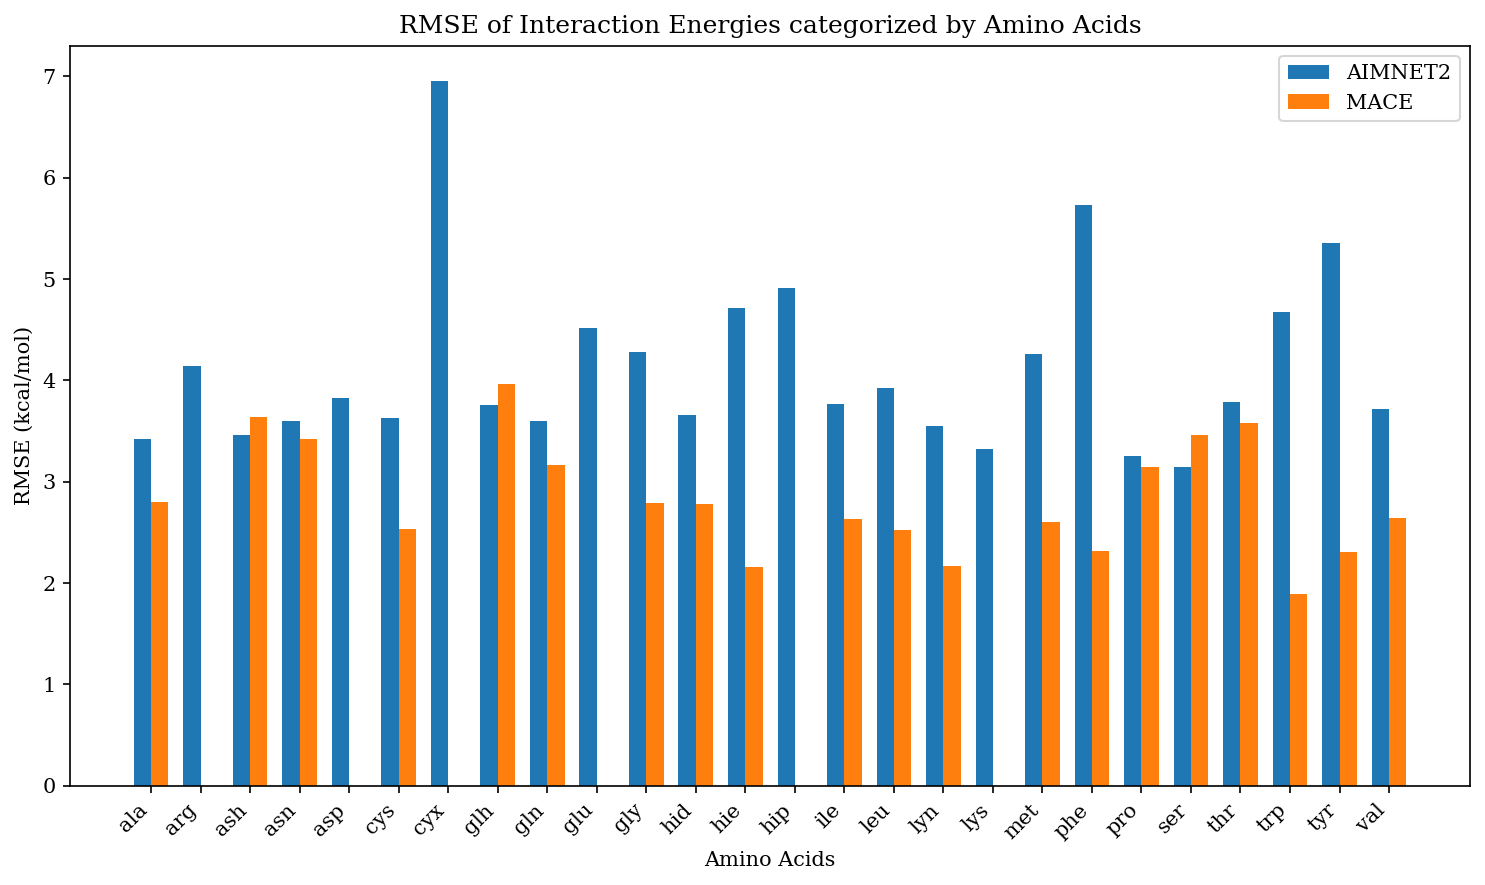

In [56]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

hartree2ev = 27.211386245988
ev2hartree = 1/hartree2ev
ev2kcalmol = 23.0605

def read_smiles_from_group(file_path, group_name, dataset_name):
    """Read a dataset from a specified group, handle KeyError if dataset not found."""
    with h5py.File(file_path, 'r') as f:
        try:
            return f[group_name][dataset_name][()]
        except KeyError:
            print(f"Dataset '{dataset_name}' not found in group '{group_name}'. Skipping...")
            return None

def is_valid_array(A, B, C):
    """Check element-wise if values are valid (i.e., not np.nan or zero) across three arrays."""
    return (~np.isnan(A)) & (~np.isnan(B)) & (~np.isnan(C)) & (A != 0) & (B != 0) & (C != 0)

def compute_E_int(total, aa, lig):
    """Compute interaction energy element-wise, return np.nan for invalid entries."""
    E_int = np.full_like(total, np.nan)
    valid_mask = is_valid_array(total, aa, lig)
    E_int[valid_mask] = (total[valid_mask] - (aa[valid_mask] + lig[valid_mask])) * hartree2ev * ev2kcalmol
    return E_int

def compute_rmse(actual, predicted):
    """Compute RMSE between two arrays."""
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    return np.sqrt(np.mean((actual[mask] - predicted[mask]) ** 2))

# File path to the HDF5 file
file_path = "solvated_spice_v2_MACE.hdf5"

# Initialize lists to store the amino acid names and RMSE values
amino_acids = []
rmse_aimnet2_vs_b973c = []
rmse_mace_vs_b973c = []

# Open the file and process the datasets group by group
with h5py.File(file_path, 'r') as f:
    for group_name in f.keys():
        amino_acids.append(group_name)  # Add amino acid name
        
        # Read datasets with error handling
        AIMNET2_b973c = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c')
        AIMNET2_b973c_AA = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_AA')
        AIMNET2_b973c_lig = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_lig')

        ORCA_b973c = read_smiles_from_group(file_path, group_name, 'dft_total_energy_b973c')
        ORCA_b973c_AA = read_smiles_from_group(file_path, group_name, 'dft_total_energy_AA_b973c')
        ORCA_b973c_lig = read_smiles_from_group(file_path, group_name, 'dft_total_energy_lig_b973c')

        MACE_b973c = read_smiles_from_group(file_path, group_name, 'MACE_wb97')
        MACE_b973c_AA = read_smiles_from_group(file_path, group_name, 'MACE_wb97_AA')
        MACE_B973C_lig = read_smiles_from_group(file_path, group_name, 'MACE_wb97_lig')
        
        # Calculate interaction energies where valid
        if AIMNET2_b973c is not None and AIMNET2_b973c_AA is not None and AIMNET2_b973c_lig is not None:
            E_int_AIMNET2 = compute_E_int(AIMNET2_b973c, AIMNET2_b973c_AA, AIMNET2_b973c_lig)
        else:
            E_int_AIMNET2 = None
        
        if ORCA_b973c is not None and ORCA_b973c_AA is not None and ORCA_b973c_lig is not None:
            E_int_b973c = compute_E_int(ORCA_b973c, ORCA_b973c_AA, ORCA_b973c_lig)
        else:
            E_int_b973c = None

        if MACE_b973c is not None and MACE_b973c_AA is not None and MACE_B973C_lig is not None:
            E_int_MACE = compute_E_int(MACE_b973c, MACE_b973c_AA, MACE_B973C_lig)
        else:
            E_int_MACE = None

        # Compute RMSE between AIMNET2 and B973C interaction energies
        if E_int_AIMNET2 is not None and E_int_b973c is not None:
            rmse_aimnet2 = compute_rmse(E_int_AIMNET2, E_int_b973c)
        else:
            rmse_aimnet2 = np.nan
        
        # Compute RMSE between MACE and B973C interaction energies
        if E_int_MACE is not None and E_int_b973c is not None:
            rmse_mace = compute_rmse(E_int_MACE, E_int_b973c)
        else:
            rmse_mace = np.nan
        
        # Append RMSE values to the lists
        rmse_aimnet2_vs_b973c.append(rmse_aimnet2)
        rmse_mace_vs_b973c.append(rmse_mace)

# Plot the RMSE values
fig, ax = plt.subplots(figsize=(10, 6))

index = np.arange(len(amino_acids))
bar_width = 0.35

bar1 = ax.bar(index, rmse_aimnet2_vs_b973c, bar_width, label='AIMNET2')
bar2 = ax.bar(index + bar_width, rmse_mace_vs_b973c, bar_width, label='MACE')

# Add labels, title, and legend
ax.set_xlabel('Amino Acids')
ax.set_ylabel('RMSE (kcal/mol)')
ax.set_title('RMSE of Interaction Energies categorized by Amino Acids')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(amino_acids, rotation=45, ha='right')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

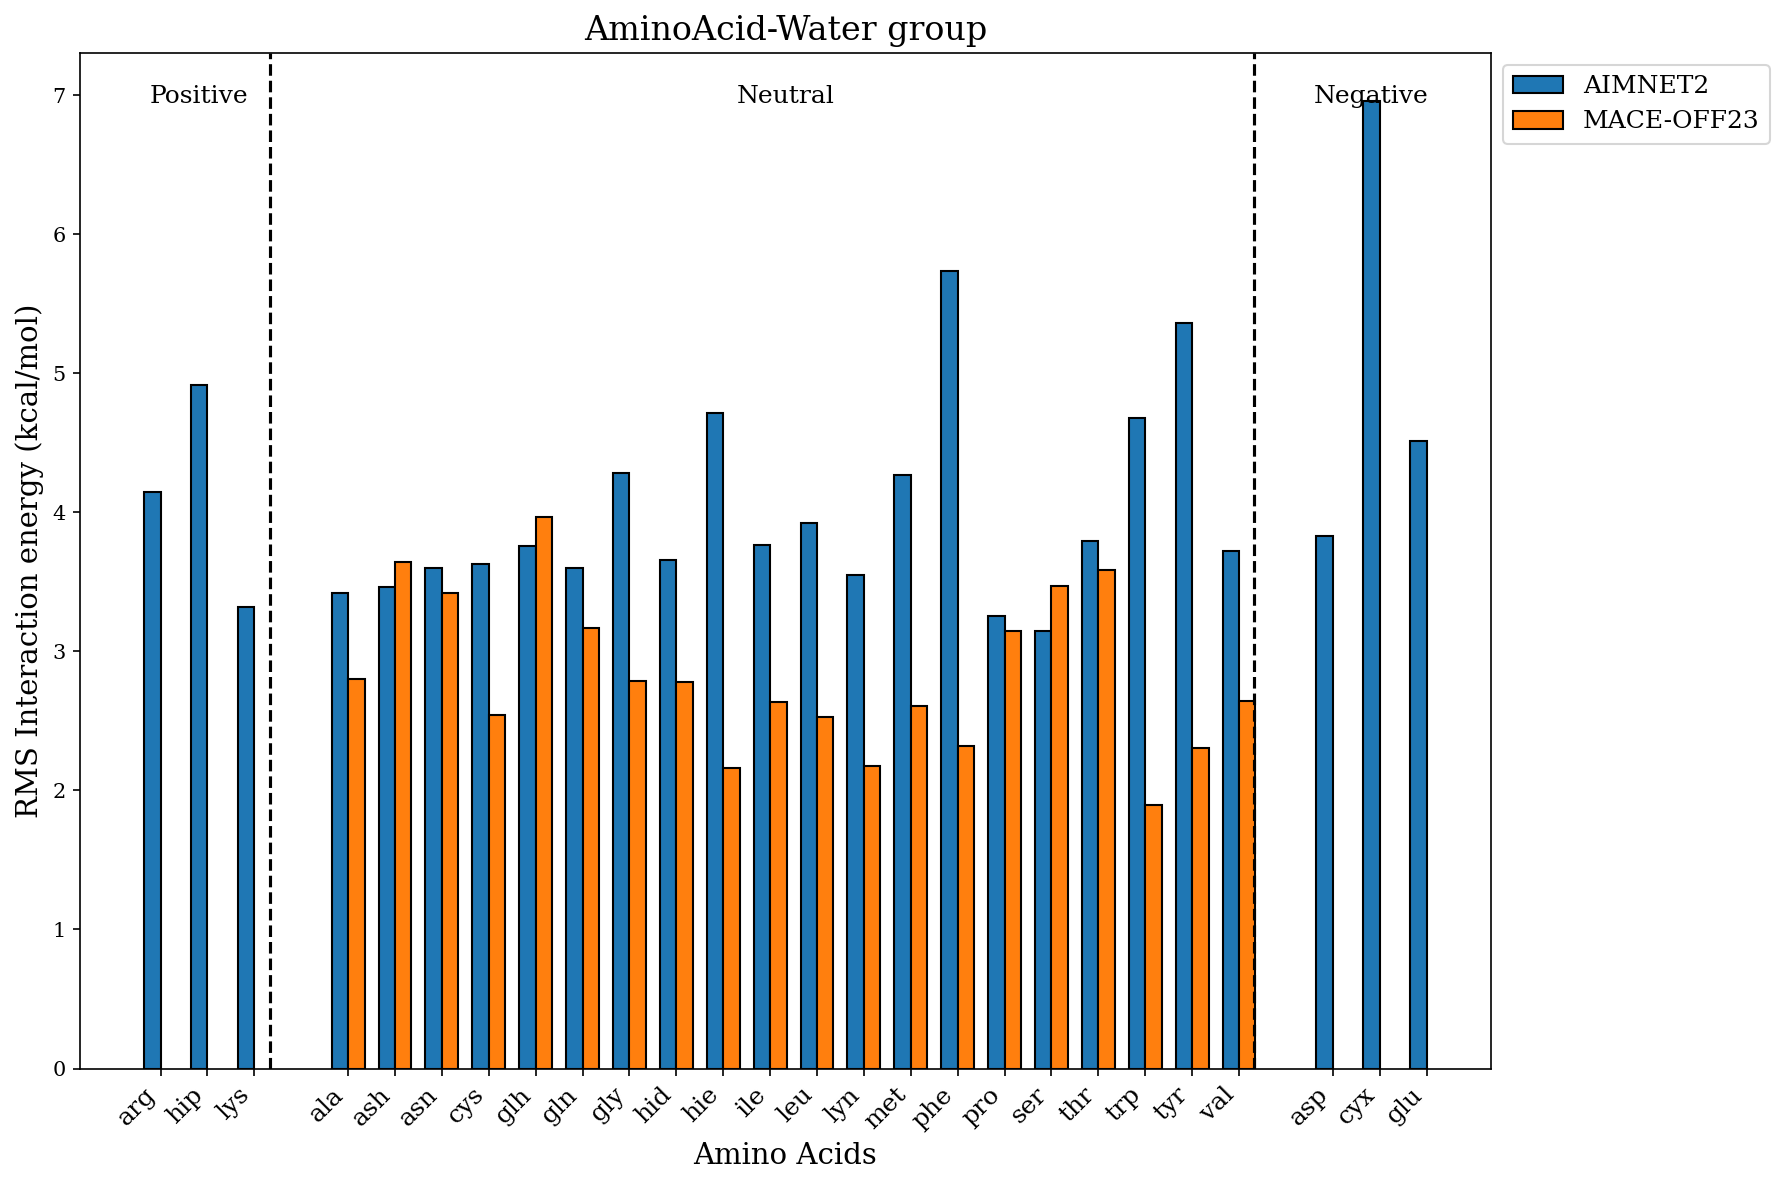

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Define color palette for AIMNET2 and MACE
aimnet2_color = '#1f77b4'  # blue for AIMNET2
mace_color = '#ff7f0e'     # orange for MACE

# Amino acids categorized by charge
positive_group = ['arg', 'hip', 'lys']
negative_group = ['asp', 'cyx', 'glu']
neutral_group = ['ala', 'ash', 'asn', 'cys', 'glh', 'gln', 'gly', 'hid', 'hie', 'ile', 'leu', 'lyn', 'met', 'phe', 'pro', 'ser', 'thr', 'trp', 'tyr', 'val']

# Create a dictionary to map amino acids to charge categories
charge_categories = {}
for aa in positive_group:
    charge_categories[aa] = 'Positive'
for aa in negative_group:
    charge_categories[aa] = 'Negative'
for aa in neutral_group:
    charge_categories[aa] = 'Neutral'

# Group amino acids by charge category
positive_acids = [aa for aa in amino_acids if charge_categories[aa] == 'Positive']
neutral_acids = [aa for aa in amino_acids if charge_categories[aa] == 'Neutral']
negative_acids = [aa for aa in amino_acids if charge_categories[aa] == 'Negative']

# Group RMSE data accordingly
positive_rmse_aimnet2 = [rmse_aimnet2_vs_b973c[amino_acids.index(aa)] for aa in positive_acids]
neutral_rmse_aimnet2 = [rmse_aimnet2_vs_b973c[amino_acids.index(aa)] for aa in neutral_acids]
negative_rmse_aimnet2 = [rmse_aimnet2_vs_b973c[amino_acids.index(aa)] for aa in negative_acids]

positive_rmse_mace = [rmse_mace_vs_b973c[amino_acids.index(aa)] for aa in positive_acids]
neutral_rmse_mace = [rmse_mace_vs_b973c[amino_acids.index(aa)] for aa in neutral_acids]
negative_rmse_mace = [rmse_mace_vs_b973c[amino_acids.index(aa)] for aa in negative_acids]

# Create a figure for the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Indices for each group of amino acids
index_positive = np.arange(len(positive_acids))
index_neutral = np.arange(len(neutral_acids)) + len(positive_acids) + 1  # +1 to create a gap between groups
index_negative = np.arange(len(negative_acids)) + len(positive_acids) + len(neutral_acids) + 2

bar_width = 0.35

# Plot bars for each charge group and RMSE method
bar1_pos = ax.bar(index_positive, positive_rmse_aimnet2, bar_width, color=aimnet2_color, edgecolor='black', label='AIMNET2')
bar2_pos = ax.bar(index_positive + bar_width, positive_rmse_mace, bar_width, color=mace_color, edgecolor='black', label='MACE-OFF23')

bar1_neu = ax.bar(index_neutral, neutral_rmse_aimnet2, bar_width, color=aimnet2_color, edgecolor='black')
bar2_neu = ax.bar(index_neutral + bar_width, neutral_rmse_mace, bar_width, color=mace_color, edgecolor='black')

bar1_neg = ax.bar(index_negative, negative_rmse_aimnet2, bar_width, color=aimnet2_color, edgecolor='black')
bar2_neg = ax.bar(index_negative + bar_width, negative_rmse_mace, bar_width, color=mace_color, edgecolor='black')

# Set labels, title, and legend
ax.set_xlabel('Amino Acids', fontsize=14)
ax.set_ylabel('RMS Interaction energy (kcal/mol)', fontsize=14)
ax.set_title('AminoAcid-Water group', fontsize=16)

# Set xticks and group them by charge
xticks_positions = np.concatenate([index_positive, index_neutral, index_negative])
xticks_labels = positive_acids + neutral_acids + negative_acids
ax.set_xticks(xticks_positions + bar_width / 2)
ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=12)

# Add vertical lines to separate the groups
ax.axvline(len(positive_acids) - 0.5, color='black', linestyle='--')
ax.axvline(len(positive_acids) + len(neutral_acids) + 0.5, color='black', linestyle='--')

# Calculate the center position for each group and add group labels
middle_positive = len(positive_acids) / 2 - 0.5
middle_neutral = len(positive_acids) + len(neutral_acids) / 2 + 0.5
middle_negative = len(positive_acids) + len(neutral_acids) + len(negative_acids) / 2 + 1.5

ax.text(middle_positive, ax.get_ylim()[1] * 0.95, 'Positive', ha='center', fontsize=12)
ax.text(middle_neutral, ax.get_ylim()[1] * 0.95, 'Neutral', ha='center', fontsize=12)
ax.text(middle_negative, ax.get_ylim()[1] * 0.95, 'Negative', ha='center', fontsize=12)

# Move legend outside of the plot
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add gridlines for better readability
# ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)

# Customize y-axis and gridlines

# ax.set_axisbelow(True)
# ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Tight layout for journal style
plt.tight_layout()

# Show plot
plt.show()


In [110]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

hartree2ev = 27.211386245988
ev2kcalmol = 23.0605

def read_smiles_from_group(file_path, group_name, dataset_name):
    """Read a dataset from a specified group, handle KeyError if dataset not found."""
    with h5py.File(file_path, 'r') as f:
        try:
            return f[group_name][dataset_name][()]
        except KeyError:
            print(f"Dataset '{dataset_name}' not found in group '{group_name}'. Skipping...")
            return None

def compute_E_int(total, aa, lig):
    """Compute interaction energy element-wise, return np.nan for invalid entries."""
    E_int = np.full_like(total, np.nan)
    valid_mask = (~np.isnan(total)) & (~np.isnan(aa)) & (~np.isnan(lig)) & (total != 0) & (aa != 0) & (lig != 0)
    E_int[valid_mask] = (total[valid_mask] - (aa[valid_mask] + lig[valid_mask])) * hartree2ev * ev2kcalmol
    return E_int

def calculate_rmse_r2(x, y):
    """Calculate RMSE and R², ignoring NaN and zero values."""
    valid_mask = (~np.isnan(x)) & (~np.isnan(y)) & (x != 0) & (y != 0)
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    if len(x_valid) == 0 or len(y_valid) == 0:
        return np.nan, np.nan

    rmse = np.sqrt(mean_squared_error(x_valid, y_valid))
    
    if len(x_valid) > 1 and len(y_valid) > 1:
        model = LinearRegression().fit(x_valid.reshape(-1, 1), y_valid)
        r2 = model.score(x_valid.reshape(-1, 1), y_valid)
    else:
        r2 = np.nan

    return rmse, r2

# File path to the HDF5 file
file_path = "AminoAcidLigand_spice_v2_MACE.hdf5"

# Initialize lists to store data
b97_aimnet2 = []
b97_mace = []
b97_ref = []

# Open the file and process the datasets group by group
with h5py.File(file_path, 'r') as f:
    for group_name in f.keys():
        # Read datasets with error handling
        AIMNET2_b973c = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c')
        AIMNET2_b973c_AA = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_AA')
        AIMNET2_b973c_lig = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_lig')

        ORCA_b973c = read_smiles_from_group(file_path, group_name, 'dft_total_energy_b973c')
        ORCA_b973c_AA = read_smiles_from_group(file_path, group_name, 'dft_total_energy_AA_b973c')
        ORCA_b973c_lig = read_smiles_from_group(file_path, group_name, 'dft_total_energy_lig_b973c')

        MACE_b973c = read_smiles_from_group(file_path, group_name, 'MACE_wb97')
        MACE_b973c_AA = read_smiles_from_group(file_path, group_name, 'MACE_wb97_AA')
        MACE_B973C_lig = read_smiles_from_group(file_path, group_name, 'MACE_wb97_lig')
        
        # Calculate interaction energies
        if AIMNET2_b973c is not None and AIMNET2_b973c_AA is not None and AIMNET2_b973c_lig is not None:
            E_int_AIMNET2 = compute_E_int(AIMNET2_b973c, AIMNET2_b973c_AA, AIMNET2_b973c_lig)
            b97_aimnet2.extend(E_int_AIMNET2.flatten())
            
        if ORCA_b973c is not None and ORCA_b973c_AA is not None and ORCA_b973c_lig is not None:
            E_int_b973c = compute_E_int(ORCA_b973c, ORCA_b973c_AA, ORCA_b973c_lig)
            b97_ref.extend(E_int_b973c.flatten())
        
        if MACE_b973c is not None and MACE_b973c_AA is not None and MACE_B973C_lig is not None:
            E_int_MACE = compute_E_int(MACE_b973c, MACE_b973c_AA, MACE_B973C_lig)
            b97_mace.extend(E_int_MACE.flatten())

# Convert lists to numpy arrays
b97_aimnet2 = np.array(b97_aimnet2)
b97_mace = np.array(b97_mace)
b97_ref = np.array(b97_ref)

# Calculate axis limits
x_min = min(np.nanmin(b97_aimnet2), np.nanmin(b97_mace))
x_max = max(np.nanmax(b97_aimnet2), np.nanmax(b97_mace))
y_min = min(np.nanmin(b97_ref), np.nanmin(b97_ref))
y_max = max(np.nanmax(b97_ref), np.nanmax(b97_ref))

# Calculate RMSE and R²
rmse_aimnet2 = calculate_rmse_r2(b97_aimnet2, b97_ref)
rmse_mace = calculate_rmse_r2(b97_mace, b97_ref)

# Create scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Scatter plot for AIMNET2 vs b97-3c
# scatter1 = axs[0].scatter(b97_aimnet2, b97_ref, alpha=0.6, c=b97_aimnet2, cmap='plasma', edgecolors='w', s=20)
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=min(np.nanmin(b97_aimnet2), np.nanmin(b97_mace)), vmax=max(np.nanmax(b97_aimnet2), np.nanmax(b97_mace)))

scatter1 = axs[0].scatter(b97_aimnet2, b97_ref, alpha=0.8, c=b97_aimnet2, cmap='inferno',  edgecolors='none', norm=norm, s=20)

# scatter2 = axs[1].scatter(b97_mace, b97_ref, alpha=0.6, c=b97_mace, cmap='inferno', edgecolors='w', s=20)


axs[0].set_xlabel('B97-3c [kcal/mol]', fontsize=14)
axs[0].set_ylabel('AIMNET2 [kcal/mol]', fontsize=14)
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].grid(True, linestyle='--', alpha=0.7)
cbar1 = plt.colorbar(scatter1, ax=axs[0])
cbar1.set_label('Interaction Energy [kcal/mol]', fontsize=12)
axs[0].text(0.05, 0.95, f'RMSE: {rmse_aimnet2[0]:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
axs[0].text(0.05, 0.90, f'R²: {rmse_aimnet2[1]:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')

# Scatter plot for MACE vs b97-3c
# scatter2 = axs[1].scatter(b97_mace, b97_ref, alpha=0.6, c=b97_mace, cmap='plasma', edgecolors='w', s=20)

# scatter2 = axs[1].scatter(b97_mace, b97_ref, alpha=1, c=b97_mace, cmap='plasma', edgecolors='w', s=20)
scatter2 = axs[1].scatter(b97_mace, b97_ref, alpha=0.8, c=b97_mace, cmap='inferno', edgecolors='none', norm=norm, s=20)


axs[1].set_xlabel('B97-3c [kcal/mol]', fontsize=14)
axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(y_min, y_max)
axs[1].grid(True, linestyle='--', alpha=0.7)
cbar2 = plt.colorbar(scatter2, ax=axs[1])
cbar2.set_label('Interaction Energy [kcal/mol]', fontsize=12)
axs[1].text(0.05, 0.95, f'RMSE: {rmse_mace[0]:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
axs[1].text(0.05, 0.90, f'R²: {rmse_mace[1]:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')

# Adjust layout for publication quality
plt.tight_layout()

# Show plot
plt.show()


Dataset 'AIMNET2_b973c' not found in group '54X VAL'. Skipping...
Dataset 'AIMNET2_b973c_AA' not found in group '54X VAL'. Skipping...
Dataset 'AIMNET2_b973c_lig' not found in group '54X VAL'. Skipping...
Dataset 'dft_total_energy_b973c' not found in group '54X VAL'. Skipping...
Dataset 'dft_total_energy_AA_b973c' not found in group '54X VAL'. Skipping...
Dataset 'dft_total_energy_lig_b973c' not found in group '54X VAL'. Skipping...
Dataset 'MACE_wb97' not found in group '54X VAL'. Skipping...
Dataset 'MACE_wb97_AA' not found in group '54X VAL'. Skipping...
Dataset 'MACE_wb97_lig' not found in group '54X VAL'. Skipping...
Dataset 'AIMNET2_b973c' not found in group '56U GLY'. Skipping...
Dataset 'AIMNET2_b973c_AA' not found in group '56U GLY'. Skipping...
Dataset 'AIMNET2_b973c_lig' not found in group '56U GLY'. Skipping...
Dataset 'dft_total_energy_b973c' not found in group '56U GLY'. Skipping...
Dataset 'dft_total_energy_AA_b973c' not found in group '56U GLY'. Skipping...
Dataset 'dft

ValueError: operands could not be broadcast together with shapes (191189,) (189535,) 

In [1]:
import os 

os.chdir("/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/sub_samples_Aminowithmace")

In [39]:
import os 

os.chdir("/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/SPICE_v2")

In [ ]:
# Helvetica or Arial 

In [37]:
!pwd

/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/sub_samples_Aminowithmace


In [16]:
from matplotlib import rcParams
# rcParams['font.family'] = 'serif'

rcParams['font.family'] = "sans-serif"
rcParams['font.size'] = 10
rcParams["figure.figsize"] = [3, 3]
rcParams["figure.dpi"] = 150.0

In [217]:
os.chdir("/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/SPICE_v2")

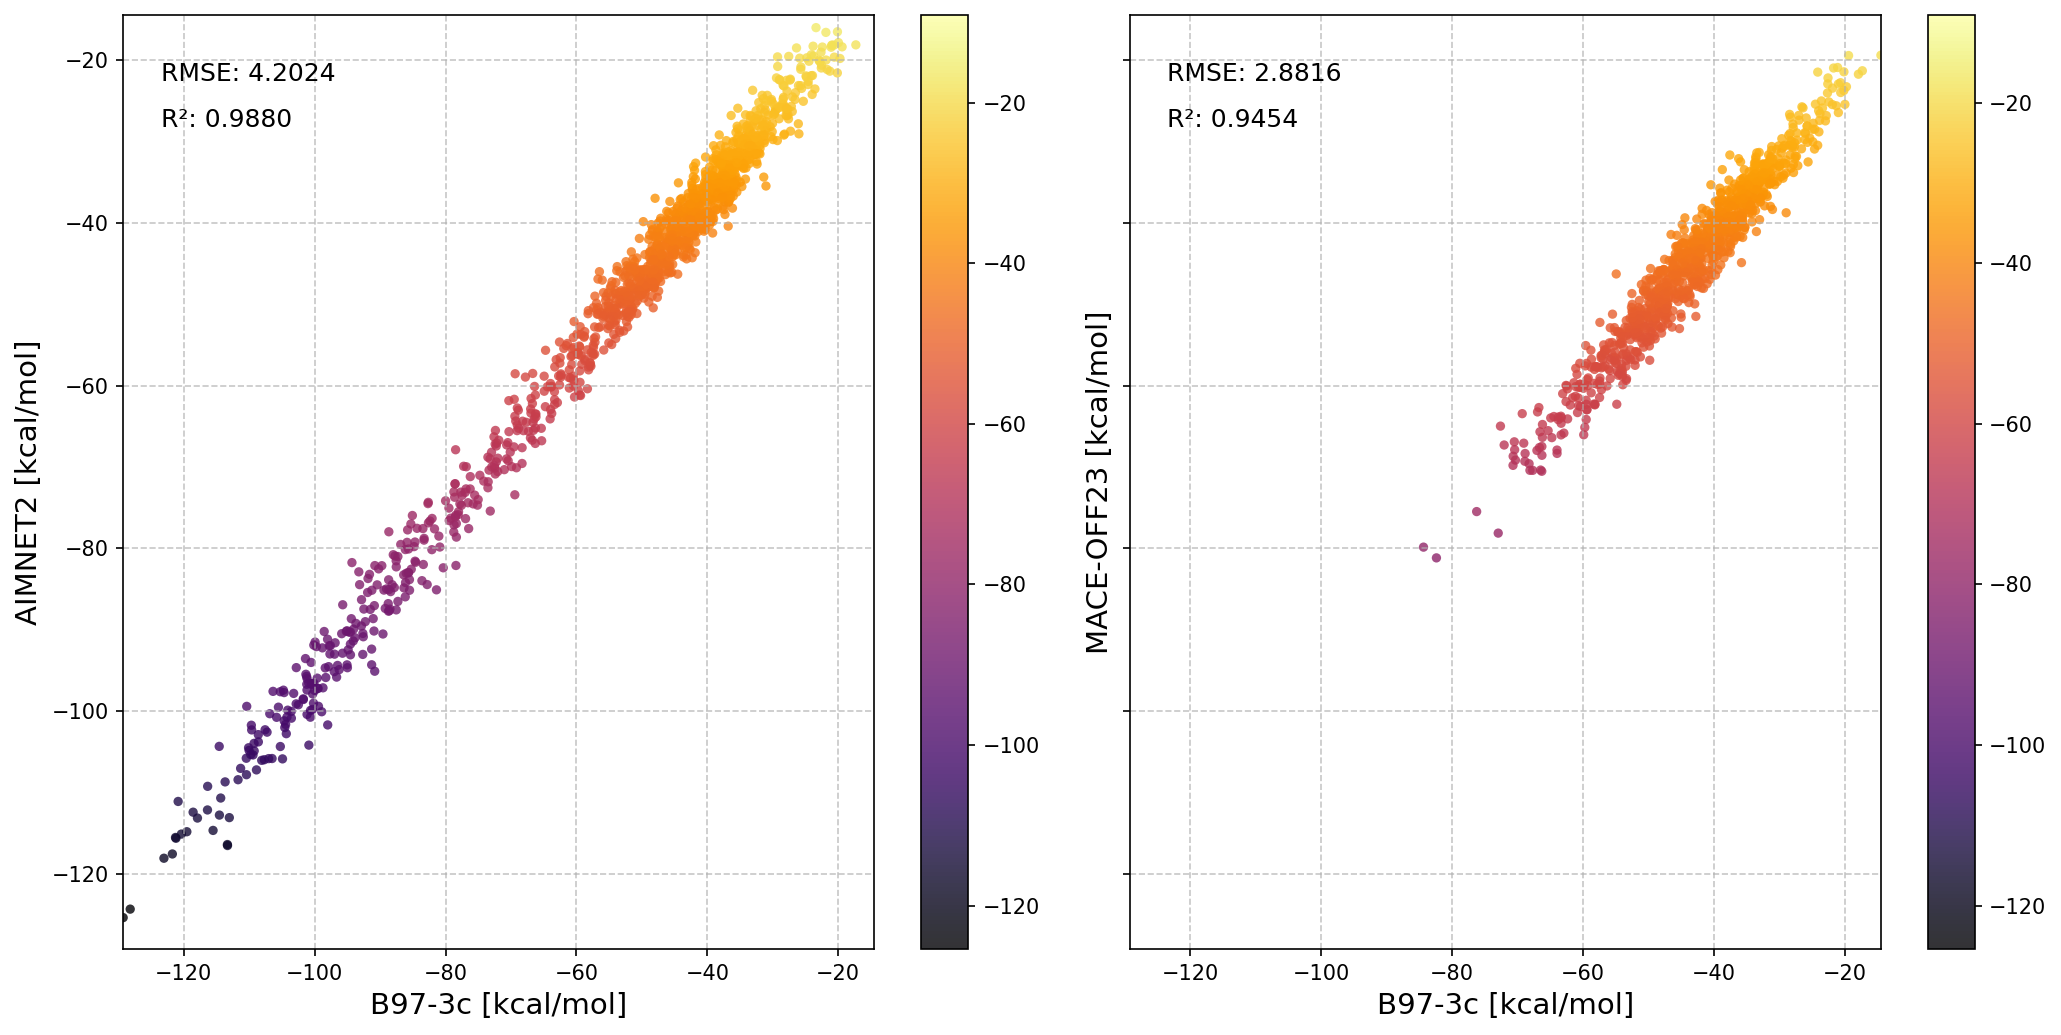

In [218]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression

hartree2ev = 27.211386245988
ev2kcalmol = 23.0605

def read_smiles_from_group(file_path, group_name, dataset_name):
    """Read a dataset from a specified group, handle KeyError if dataset not found."""
    with h5py.File(file_path, 'r') as f:
        try:
            return f[group_name][dataset_name][()]
        except KeyError:
            print(f"Dataset '{dataset_name}' not found in group '{group_name}'. Skipping...")
            return None

def compute_E_int(total, aa, lig):
    """Compute interaction energy element-wise, return np.nan for invalid entries."""
    E_int = np.full_like(total, np.nan)
    valid_mask = (~np.isnan(total)) & (~np.isnan(aa)) & (~np.isnan(lig)) & (total != 0) & (aa != 0) & (lig != 0)
    E_int[valid_mask] = (total[valid_mask] - (aa[valid_mask] + lig[valid_mask])) * hartree2ev * ev2kcalmol
    return E_int

def calculate_rmse_r2(x, y):
    """Calculate RMSE and R², ignoring NaN and zero values."""
    valid_mask = (~np.isnan(x)) & (~np.isnan(y)) & (x != 0) & (y != 0)
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    if len(x_valid) == 0 or len(y_valid) == 0:
        return np.nan, np.nan

    rmse = np.sqrt(mean_squared_error(x_valid, y_valid))
    
    if len(x_valid) > 1 and len(y_valid) > 1:
        model = LinearRegression().fit(x_valid.reshape(-1, 1), y_valid)
        r2 = model.score(x_valid.reshape(-1, 1), y_valid)
    else:
        r2 = np.nan

    return rmse, r2


def calculate_mae(x, y):
    """Calculate MAE, ignoring NaN and zero values."""
    valid_mask = (~np.isnan(x)) & (~np.isnan(y)) & (x != 0) & (y != 0)
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    if len(x_valid) == 0 or len(y_valid) == 0:
        return np.nan

    mae = mean_absolute_error(x_valid, y_valid)
    return mae


# File path to the HDF5 file
# file_path = "AminoAcidLigand_v2.1_1.hdf5"
file_path = "solvated_spice_v2_MACE.hdf5"

# Initialize lists to store data
b97_aimnet2 = []
b97_mace = []
b97_ref = []

# Open the file and process the datasets group by group
with h5py.File(file_path, 'r') as f:
    for group_name in f.keys():
        # Read datasets with error handling
        AIMNET2_b973c = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c')
        AIMNET2_b973c_AA = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_AA')
        AIMNET2_b973c_lig = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_lig')

        ORCA_b973c = read_smiles_from_group(file_path, group_name, 'dft_total_energy_b973c')
        ORCA_b973c_AA = read_smiles_from_group(file_path, group_name, 'dft_total_energy_AA_b973c')
        ORCA_b973c_lig = read_smiles_from_group(file_path, group_name, 'dft_total_energy_lig_b973c')

        MACE_b973c = read_smiles_from_group(file_path, group_name, 'MACE_wb97')
        MACE_b973c_AA = read_smiles_from_group(file_path, group_name, 'MACE_wb97_AA')
        MACE_B973C_lig = read_smiles_from_group(file_path, group_name, 'MACE_wb97_lig')
        
        # Calculate interaction energies
        if AIMNET2_b973c is not None and AIMNET2_b973c_AA is not None and AIMNET2_b973c_lig is not None:
            E_int_AIMNET2 = compute_E_int(AIMNET2_b973c, AIMNET2_b973c_AA, AIMNET2_b973c_lig)
            b97_aimnet2.extend(E_int_AIMNET2.flatten())
            
        if ORCA_b973c is not None and ORCA_b973c_AA is not None and ORCA_b973c_lig is not None:
            E_int_b973c = compute_E_int(ORCA_b973c, ORCA_b973c_AA, ORCA_b973c_lig)
            b97_ref.extend(E_int_b973c.flatten())
        
        if MACE_b973c is not None and MACE_b973c_AA is not None and MACE_B973C_lig is not None:
            E_int_MACE = compute_E_int(MACE_b973c, MACE_b973c_AA, MACE_B973C_lig)
            b97_mace.extend(E_int_MACE.flatten())

# Convert lists to numpy arrays
b97_aimnet2 = np.array(b97_aimnet2)
b97_mace = np.array(b97_mace)
b97_ref = np.array(b97_ref)

# Calculate axis limits
# x_min = min(np.nanmin(b97_aimnet2), np.nanmin(b97_mace))
# x_max = max(np.nanmax(b97_aimnet2), np.nanmax(b97_mace))

x_min = min(np.nanmin(b97_ref), np.nanmin(b97_ref))
x_max = max(np.nanmax(b97_ref), np.nanmax(b97_ref))
y_min = min(np.nanmin(b97_ref), np.nanmin(b97_ref))
y_max = max(np.nanmax(b97_ref), np.nanmax(b97_ref))

# Calculate RMSE and R²
rmse_aimnet2 = calculate_rmse_r2(b97_aimnet2, b97_ref)
rmse_mace = calculate_rmse_r2(b97_mace, b97_ref)

# Create scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Scatter plot for AIMNET2 vs b97-3c
# scatter1 = axs[0].scatter(b97_aimnet2, b97_ref, alpha=0.6, c=b97_aimnet2, cmap='plasma', edgecolors='w', s=20)
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=min(np.nanmin(b97_aimnet2), np.nanmin(b97_mace)), vmax=max(np.nanmax(b97_aimnet2), np.nanmax(b97_mace)))

# scatter1 = axs[0].scatter(b97_aimnet2, b97_ref, alpha=0.8, c=b97_aimnet2, cmap='inferno',  edgecolors='none', norm=norm, s=20)
scatter1 = axs[0].scatter(b97_ref, b97_aimnet2, alpha=0.8, c=b97_aimnet2, cmap='inferno',  edgecolors='none', norm=norm, s=20)


axs[0].set_xlabel('B97-3c [kcal/mol]', fontsize=14)
axs[0].set_ylabel('AIMNET2 [kcal/mol]', fontsize=14)
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].grid(True, linestyle='--', alpha=0.7)
cbar1 = plt.colorbar(scatter1, ax=axs[0])
# cbar1.set_label('Interaction Energy [kcal/mol]', fontsize=12)
axs[0].text(0.05, 0.95, f'RMSE: {rmse_aimnet2[0]:.4f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
axs[0].text(0.05, 0.90, f'R²: {rmse_aimnet2[1]:.4f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')

# Scatter plot for MACE vs b97-3c
# scatter2 = axs[1].scatter(b97_mace, b97_ref, alpha=0.6, c=b97_mace, cmap='plasma', edgecolors='w', s=20)
scatter2 = axs[1].scatter(b97_ref, b97_mace, alpha=0.8, c=b97_mace, cmap='inferno', edgecolors='none', norm=norm, s=20)
axs[1].set_xlabel('B97-3c [kcal/mol]', fontsize=14)
axs[1].set_ylabel('MACE-OFF23 [kcal/mol]', fontsize=14)

axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(y_min, y_max)
axs[1].grid(True, linestyle='--', alpha=0.7)
cbar2 = plt.colorbar(scatter2, ax=axs[1])
# cbar2.set_label('Interaction Energy [kcal/mol]', fontsize=12)
axs[1].text(0.05, 0.95, f'RMSE: {rmse_mace[0]:.4f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
axs[1].text(0.05, 0.90, f'R²: {rmse_mace[1]:.4f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')

# Adjust layout for publication quality
plt.tight_layout()

plt.savefig('RMSE_scatter.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [ ]:
import h5py

def merge_hdf5_files(output_file, input_files):
    with h5py.File(output_file, 'w') as hf_out:
        for index, file in enumerate(input_files):
            print(f"Processing file {index + 1}/{len(input_files)}: {file}")
            try:
                with h5py.File(file, 'r') as hf_in:

                    for group in hf_in.keys():
                        # print(f"  Copying group: {group} from {file}")
                        if group not in hf_out:

                            hf_in.copy(group, hf_out)
                        else:

                            hf_in.copy(group, hf_out, name=f"{group}_{file.split('_')[-1].split('.')[0]}")
            except Exception as e:
                print(f"Error while processing {file} {index}: {e}")


input_files = [f"AminoAcidLigand_v2.1_{i}.hdf5" for i in range(1, 196)]
output_file = "AminoAcidLigand_spice_v2_MACE.hdf5"

# Merge the files
merge_hdf5_files(output_file, input_files)

print(f"Files merged successfully into {output_file}")

In [124]:
rmse_aimnet2

25.942687455883192

In [118]:
b97_aimnet2

array([           nan, -23.8279363425, -24.8449901678, ...,
       -24.9779094774, -32.6638864829, -31.5346609526])

In [115]:
len(b97_ref)

1300

In [125]:
!pwd

/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/SPICE_v2


In [ ]:
!p

In [127]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

hartree2ev = 27.211386245988
ev2kcalmol = 23.0605

def read_smiles_from_group(file_path, group_name, dataset_name):
    """Read a dataset from a specified group, handle KeyError if dataset not found."""
    with h5py.File(file_path, 'r') as f:
        try:
            return f[group_name][dataset_name][()]
        except KeyError:
            print(f"Dataset '{dataset_name}' not found in group '{group_name}'. Skipping...")
            return None

def compute_E_int(total, aa, lig):
    """Compute interaction energy element-wise, return np.nan for invalid entries."""
    E_int = np.full_like(total, np.nan)
    valid_mask = (~np.isnan(total)) & (~np.isnan(aa)) & (~np.isnan(lig)) & (total != 0) & (aa != 0) & (lig != 0)
    E_int[valid_mask] = (total[valid_mask] - (aa[valid_mask] + lig[valid_mask])) * hartree2ev * ev2kcalmol
    return E_int

def calculate_rmse_mae(x, y):
    """Calculate RMSE and MAE, ignoring NaN values."""
    valid_mask = (~np.isnan(x)) & (~np.isnan(y))
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    if len(x_valid) == 0 or len(y_valid) == 0:
        return np.nan, np.nan, np.nan

    rmse = np.sqrt(mean_squared_error(x_valid, y_valid))
    mae = np.mean(np.abs(x_valid - y_valid))
    
    if len(x_valid) > 1:
        model = LinearRegression().fit(x_valid.reshape(-1, 1), y_valid)
        r2 = model.score(x_valid.reshape(-1, 1), y_valid)
    else:
        r2 = np.nan

    return rmse, mae, r2

# File path to the HDF5 file
file_path = "AminoAcidLigand_spice_v2_MACE.hdf5"

# Initialize lists to store data
b97_aimnet2 = []
b97_mace = []
b97_ref = []

# Open the file and process the datasets group by group
with h5py.File(file_path, 'r') as f:
    for group_name in f.keys():
        # Read datasets with error handling
        AIMNET2_b973c = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c')
        AIMNET2_b973c_AA = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_AA')
        AIMNET2_b973c_lig = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_lig')

        ORCA_b973c = read_smiles_from_group(file_path, group_name, 'dft_total_energy_b973c')
        ORCA_b973c_AA = read_smiles_from_group(file_path, group_name, 'dft_total_energy_AA_b973c')
        ORCA_b973c_lig = read_smiles_from_group(file_path, group_name, 'dft_total_energy_lig_b973c')

        MACE_b973c = read_smiles_from_group(file_path, group_name, 'MACE_wb97')
        MACE_b973c_AA = read_smiles_from_group(file_path, group_name, 'MACE_wb97_AA')
        MACE_B973C_lig = read_smiles_from_group(file_path, group_name, 'MACE_wb97_lig')
        
        # Calculate interaction energies
        if AIMNET2_b973c is not None and AIMNET2_b973c_AA is not None and AIMNET2_b973c_lig is not None:
            E_int_AIMNET2 = compute_E_int(AIMNET2_b973c, AIMNET2_b973c_AA, AIMNET2_b973c_lig)
            b97_aimnet2.extend(E_int_AIMNET2.flatten())
            
        if ORCA_b973c is not None and ORCA_b973c_AA is not None and ORCA_b973c_lig is not None:
            E_int_b973c = compute_E_int(ORCA_b973c, ORCA_b973c_AA, ORCA_b973c_lig)
            b97_ref.extend(E_int_b973c.flatten())
        
        if MACE_b973c is not None and MACE_b973c_AA is not None and MACE_B973C_lig is not None:
            E_int_MACE = compute_E_int(MACE_b973c, MACE_b973c_AA, MACE_B973C_lig)
            b97_mace.extend(E_int_MACE.flatten())

# Convert lists to numpy arrays
b97_aimnet2 = np.array(b97_aimnet2)
b97_mace = np.array(b97_mace)
b97_ref = np.array(b97_ref)

# Calculate axis limits
x_min = min(np.nanmin(b97_aimnet2), np.nanmin(b97_mace))
x_max = max(np.nanmax(b97_aimnet2), np.nanmax(b97_mace))
y_min = min(np.nanmin(b97_ref), np.nanmin(b97_ref))
y_max = max(np.nanmax(b97_ref), np.nanmax(b97_ref))

# Calculate RMSE, MAE, and R²
rmse_aimnet2, mae_aimnet2, r2_aimnet2 = calculate_rmse_mae(b97_aimnet2, b97_ref)
rmse_mace, mae_mace, r2_mace = calculate_rmse_mae(b97_mace, b97_ref)

# Create scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Scatter plot for AIMNET2 vs b97-3c
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=min(np.nanmin(b97_aimnet2), np.nanmin(b97_mace)), vmax=max(np.nanmax(b97_aimnet2), np.nanmax(b97_mace)))

scatter1 = axs[0].scatter(b97_aimnet2, b97_ref, alpha=0.8, c=b97_aimnet2, cmap='inferno', edgecolors='none', norm=norm, s=20)
axs[0].set_xlabel('AIMNET2 [kcal/mol]', fontsize=14)
axs[0].set_ylabel('B97-3c [kcal/mol]', fontsize=14)
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].grid(True, linestyle='--', alpha=0.7)
cbar1 = plt.colorbar(scatter1, ax=axs[0])
cbar1.set_label('Interaction Energy [kcal/mol]', fontsize=12)
axs[0].text(0.05, 0.95, f'RMSE: {rmse_aimnet2:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
axs[0].text(0.05, 0.90, f'MAE: {mae_aimnet2:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
axs[0].text(0.05, 0.85, f'R²: {r2_aimnet2:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')

# Scatter plot for MACE vs b97-3c
scatter2 = axs[1].scatter(b97_mace, b97_ref, alpha=0.8, c=b97_mace, cmap='inferno', edgecolors='none', norm=norm, s=20)
axs[1].set_xlabel('MACE-OFF23 [kcal/mol]', fontsize=14)
axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(y_min, y_max)
axs[1].grid(True, linestyle='--', alpha=0.7)
cbar2 = plt.colorbar(scatter2, ax=axs[1])
cbar2.set_label('Interaction Energy [kcal/mol]', fontsize=12)
axs[1].text(0.05, 0.95, f'RMSE: {rmse_mace:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
axs[1].text(0.05, 0.90, f'MAE: {mae_mace:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
axs[1].text(0.05, 0.85, f'R²: {r2_mace:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')

# Adjust layout for publication quality
plt.tight_layout()
plt.savefig('RMSE_int.png', dpi=300)

# Show plot
plt.show()


Dataset 'AIMNET2_b973c' not found in group '54X VAL'. Skipping...
Dataset 'AIMNET2_b973c_AA' not found in group '54X VAL'. Skipping...
Dataset 'AIMNET2_b973c_lig' not found in group '54X VAL'. Skipping...
Dataset 'dft_total_energy_b973c' not found in group '54X VAL'. Skipping...
Dataset 'dft_total_energy_AA_b973c' not found in group '54X VAL'. Skipping...
Dataset 'dft_total_energy_lig_b973c' not found in group '54X VAL'. Skipping...
Dataset 'MACE_wb97' not found in group '54X VAL'. Skipping...
Dataset 'MACE_wb97_AA' not found in group '54X VAL'. Skipping...
Dataset 'MACE_wb97_lig' not found in group '54X VAL'. Skipping...
Dataset 'AIMNET2_b973c' not found in group '56U GLY'. Skipping...
Dataset 'AIMNET2_b973c_AA' not found in group '56U GLY'. Skipping...
Dataset 'AIMNET2_b973c_lig' not found in group '56U GLY'. Skipping...
Dataset 'dft_total_energy_b973c' not found in group '56U GLY'. Skipping...
Dataset 'dft_total_energy_AA_b973c' not found in group '56U GLY'. Skipping...
Dataset 'dft

KeyboardInterrupt: 

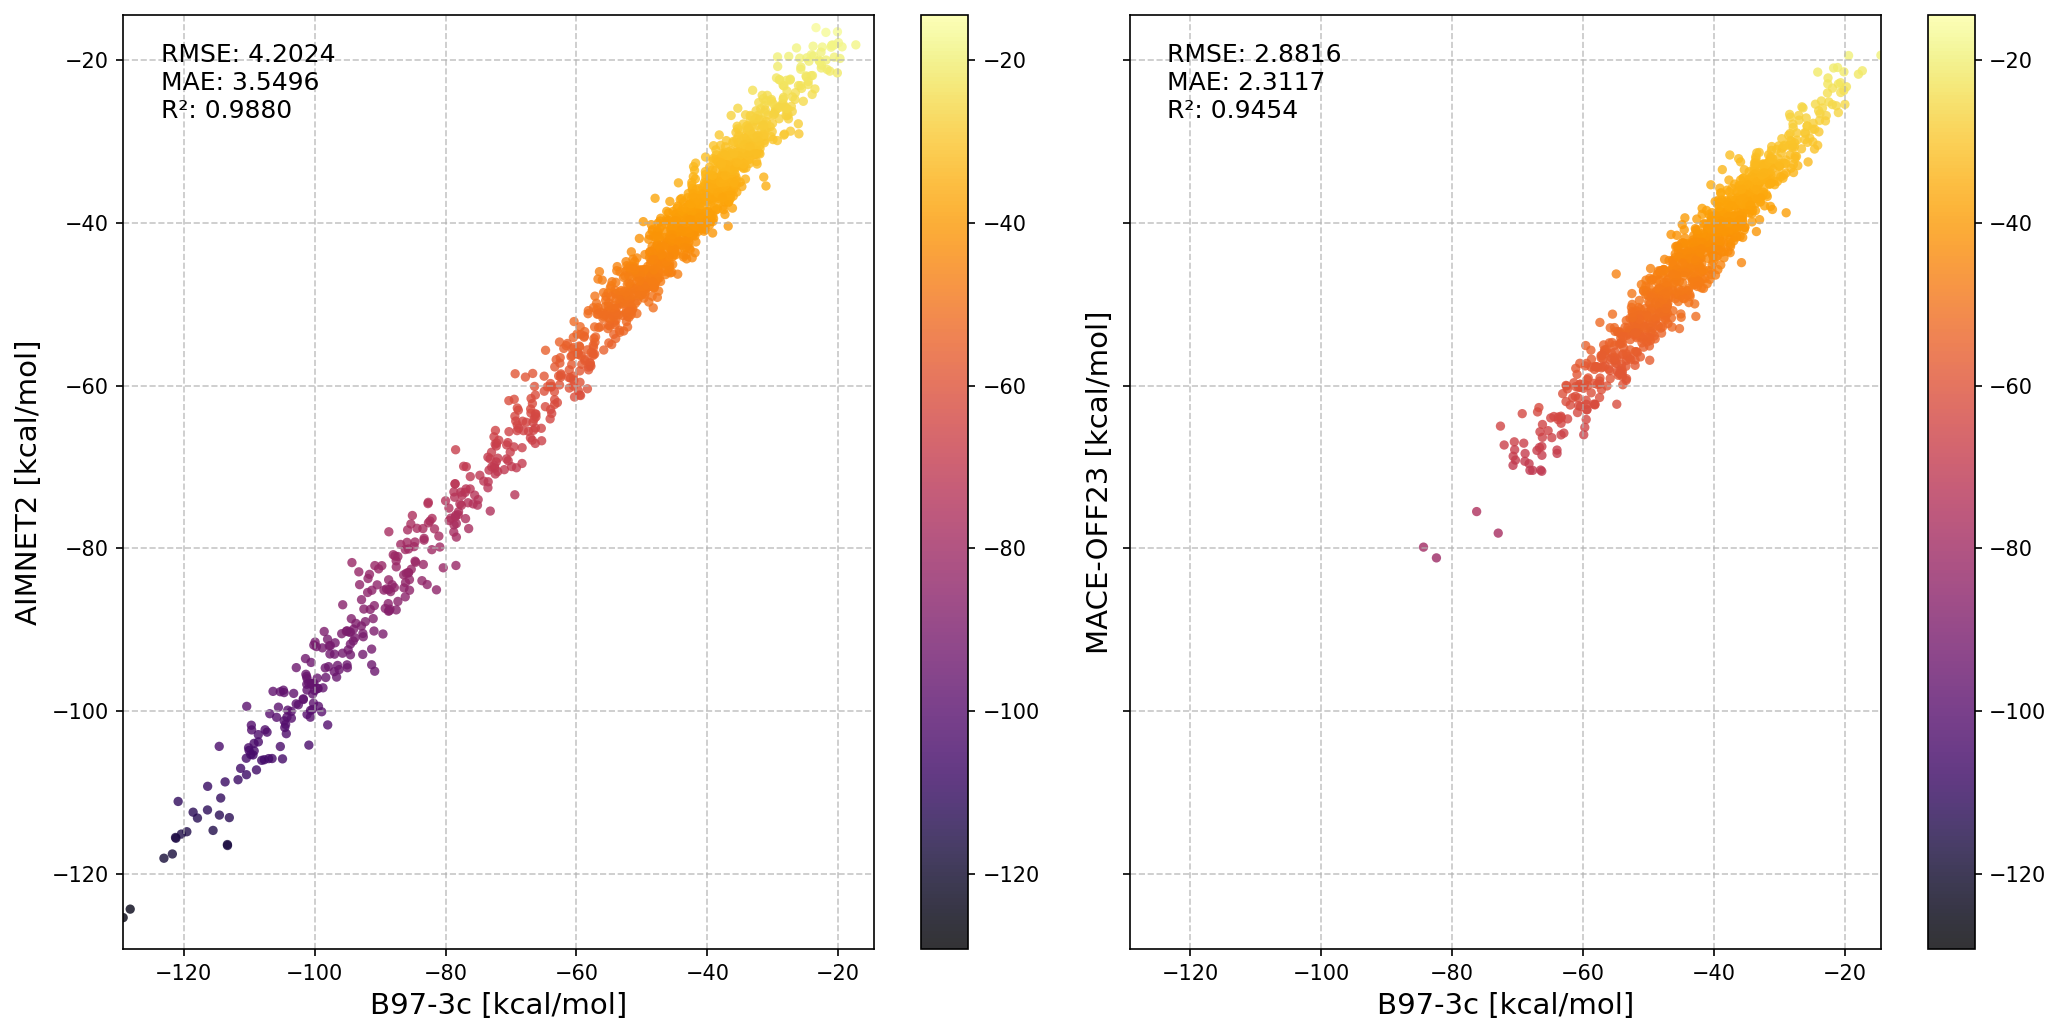

In [220]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

hartree2ev = 27.211386245988
ev2kcalmol = 23.0605

def read_smiles_from_group(file_path, group_name, dataset_name):
    """Read a dataset from a specified group, handle KeyError if dataset not found."""
    with h5py.File(file_path, 'r') as f:
        try:
            return f[group_name][dataset_name][()]
        except KeyError:
            print(f"Dataset '{dataset_name}' not found in group '{group_name}'. Skipping...")
            return None

def compute_E_int(total, aa, lig):
    """Compute interaction energy element-wise, return np.nan for invalid entries."""
    E_int = np.full_like(total, np.nan)
    valid_mask = (~np.isnan(total)) & (~np.isnan(aa)) & (~np.isnan(lig)) & (total != 0) & (aa != 0) & (lig != 0)
    E_int[valid_mask] = (total[valid_mask] - (aa[valid_mask] + lig[valid_mask])) * hartree2ev * ev2kcalmol
    return E_int

def calculate_rmse_r2(x, y):
    """Calculate RMSE and R², ignoring NaN and zero values."""
    valid_mask = (~np.isnan(x)) & (~np.isnan(y)) & (x != 0) & (y != 0)
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    if len(x_valid) == 0 or len(y_valid) == 0:
        return np.nan, np.nan

    rmse = np.sqrt(mean_squared_error(x_valid, y_valid))
    
    if len(x_valid) > 1 and len(y_valid) > 1:
        model = LinearRegression().fit(x_valid.reshape(-1, 1), y_valid)
        r2 = model.score(x_valid.reshape(-1, 1), y_valid)
    else:
        r2 = np.nan

    return rmse, r2

def calculate_mae(x, y):
    """Calculate MAE, ignoring NaN and zero values."""
    valid_mask = (~np.isnan(x)) & (~np.isnan(y)) & (x != 0) & (y != 0)
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    if len(x_valid) == 0 or len(y_valid) == 0:
        return np.nan

    mae = mean_absolute_error(x_valid, y_valid)
    return mae

# File path to the HDF5 file
file_path = "solvated_spice_v2_MACE.hdf5"

# Initialize lists to store data
b97_aimnet2 = []
b97_mace = []
b97_ref = []

# Open the file and process the datasets group by group
with h5py.File(file_path, 'r') as f:
    for group_name in f.keys():
        # Read datasets with error handling
        AIMNET2_b973c = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c')
        AIMNET2_b973c_AA = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_AA')
        AIMNET2_b973c_lig = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_lig')

        ORCA_b973c = read_smiles_from_group(file_path, group_name, 'dft_total_energy_b973c')
        ORCA_b973c_AA = read_smiles_from_group(file_path, group_name, 'dft_total_energy_AA_b973c')
        ORCA_b973c_lig = read_smiles_from_group(file_path, group_name, 'dft_total_energy_lig_b973c')

        MACE_b973c = read_smiles_from_group(file_path, group_name, 'MACE_wb97')
        MACE_b973c_AA = read_smiles_from_group(file_path, group_name, 'MACE_wb97_AA')
        MACE_B973C_lig = read_smiles_from_group(file_path, group_name, 'MACE_wb97_lig')
        
        # Calculate interaction energies
        if AIMNET2_b973c is not None and AIMNET2_b973c_AA is not None and AIMNET2_b973c_lig is not None:
            E_int_AIMNET2 = compute_E_int(AIMNET2_b973c, AIMNET2_b973c_AA, AIMNET2_b973c_lig)
            b97_aimnet2.extend(E_int_AIMNET2.flatten())
            
        if ORCA_b973c is not None and ORCA_b973c_AA is not None and ORCA_b973c_lig is not None:
            E_int_b973c = compute_E_int(ORCA_b973c, ORCA_b973c_AA, ORCA_b973c_lig)
            b97_ref.extend(E_int_b973c.flatten())
        
        if MACE_b973c is not None and MACE_b973c_AA is not None and MACE_B973C_lig is not None:
            E_int_MACE = compute_E_int(MACE_b973c, MACE_b973c_AA, MACE_B973C_lig)
            b97_mace.extend(E_int_MACE.flatten())

# Convert lists to numpy arrays
b97_aimnet2 = np.array(b97_aimnet2)
b97_mace = np.array(b97_mace)
b97_ref = np.array(b97_ref)

# Calculate axis limits
# x_min = min(np.nanmin(b97_aimnet2), np.nanmin(b97_mace))
# x_max = max(np.nanmax(b97_aimnet2), np.nanmax(b97_mace))
x_min = min(np.nanmin(b97_ref), np.nanmin(b97_ref))
x_max = max(np.nanmax(b97_ref), np.nanmax(b97_ref))
y_min = min(np.nanmin(b97_ref), np.nanmin(b97_ref))
y_max = max(np.nanmax(b97_ref), np.nanmax(b97_ref))

# Calculate RMSE, R², and MAE
rmse_aimnet2 = calculate_rmse_r2(b97_aimnet2, b97_ref)
mae_aimnet2 = calculate_mae(b97_aimnet2, b97_ref)

rmse_mace = calculate_rmse_r2(b97_mace, b97_ref)
mae_mace = calculate_mae(b97_mace, b97_ref)

# Normalize the colormap
norm = mcolors.Normalize(vmin=min(x_min, x_max), vmax=max(x_min, x_max))

# Create scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Scatter plot for AIMNET2 vs b97-3c
scatter1 = axs[0].scatter(b97_ref, b97_aimnet2, alpha=0.8, c=b97_aimnet2, cmap='inferno', edgecolors='none', norm=norm, s=20)
axs[0].set_xlabel('B97-3c [kcal/mol]', fontsize=14)
axs[0].set_ylabel('AIMNET2 [kcal/mol]', fontsize=14)
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].grid(True, linestyle='--', alpha=0.7)

cbar1 = plt.colorbar(scatter1, ax=axs[0])
# cbar1.set_label('Interaction Energy [kcal/mol]', fontsize=12)
axs[0].text(0.05, 0.97, f'RMSE: {rmse_aimnet2[0]:.4f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
axs[0].text(0.05, 0.91, f'R²: {rmse_aimnet2[1]:.4f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
axs[0].text(0.05, 0.94, f'MAE: {mae_aimnet2:.4f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')

# Scatter plot for MACE vs b97-3c
scatter2 = axs[1].scatter(b97_ref, b97_mace, alpha=0.8, c=b97_mace, cmap='inferno', edgecolors='none', norm=norm, s=20)
axs[1].set_xlabel('B97-3c [kcal/mol]', fontsize=14)
axs[1].set_ylabel('MACE-OFF23 [kcal/mol]', fontsize=14)


axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(y_min, y_max)
axs[1].grid(True, linestyle='--', alpha=0.7)
cbar2 = plt.colorbar(scatter2, ax=axs[1])
# cbar2.set_label('Interaction Energy [kcal/mol]', fontsize=12)
axs[1].text(0.05, 0.97, f'RMSE: {rmse_mace[0]:.4f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
axs[1].text(0.05, 0.91, f'R²: {rmse_mace[1]:.4f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
axs[1].text(0.05, 0.94, f'MAE: {mae_mace:.4f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')

# Adjust layout for publication quality
plt.tight_layout()
plt.savefig('RMSE_scatter.png', dpi=300, bbox_inches='tight')


# Show plot
plt.show()


In [7]:
from matplotlib import rcParams
# rcParams['font.family'] = 'serif'

rcParams['font.family'] = "sans-serif"
rcParams['font.size'] = 10
rcParams["figure.figsize"] = [3, 3]
rcParams["figure.dpi"] = 150.0

In [5]:
import os

# os.chdir("/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/SPICE_v2")

os.chdir("/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/sub_samples_Aminowithmace/temp/temp")

In [22]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

hartree2ev = 27.211386245988
ev2kcalmol = 23.0605

def read_smiles_from_group(file_path, group_name, dataset_name):
    """Read a dataset from a specified group, handle KeyError if dataset not found."""
    with h5py.File(file_path, 'r') as f:
        try:
            return f[group_name][dataset_name][()]
        except KeyError:
            return None

def compute_E_int(total, aa, lig):
    """Compute interaction energy element-wise, return np.nan for invalid entries."""
    E_int = np.full_like(total, np.nan)
    valid_mask = (~np.isnan(total)) & (~np.isnan(aa)) & (~np.isnan(lig)) & (total != 0) & (aa != 0) & (lig != 0)
    E_int[valid_mask] = (total[valid_mask] - (aa[valid_mask] + lig[valid_mask])) * hartree2ev * ev2kcalmol
    return E_int

def calculate_rmse_r2(x, y):
    """Calculate RMSE and R², ignoring NaN and zero values."""
    valid_mask = (~np.isnan(x)) & (~np.isnan(y)) & (x != 0) & (y != 0)
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    if len(x_valid) == 0 or len(y_valid) == 0:
        return np.nan, np.nan

    rmse = np.sqrt(mean_squared_error(x_valid, y_valid))
    
    if len(x_valid) > 1 and len(y_valid) > 1:
        model = LinearRegression().fit(x_valid.reshape(-1, 1), y_valid)
        r2 = model.score(x_valid.reshape(-1, 1), y_valid)
    else:
        r2 = np.nan

    return rmse, r2

def calculate_mae(x, y):
    """Calculate MAE, ignoring NaN and zero values.""" 
    valid_mask = (~np.isnan(x)) & (~np.isnan(y)) & (x != 0) & (y != 0)
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    if len(x_valid) == 0 or len(y_valid) == 0:
        return np.nan

    mae = mean_absolute_error(x_valid, y_valid)
    return mae

# Calculate axis limits
x_min = -150
x_max = 0
y_min = -150
y_max = 0

# Loop over all files from 1.hdf5 to 195.hdf5
for i in range(1, 5):
    file_path = f"AminoAcidLigand_v2.1_{i}.hdf5"
    print(file_path)

    # Initialize lists to store data for each file
    b97_aimnet2 = []
    b97_mace = []
    b97_ref = []

    # Open the file and process the datasets group by group
    with h5py.File(file_path, 'r') as f:
        for group_name in f.keys():
            # Read datasets with error handling
            AIMNET2_b973c = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c')
            AIMNET2_b973c_AA = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_AA')
            AIMNET2_b973c_lig = read_smiles_from_group(file_path, group_name, 'AIMNET2_b973c_lig')

            ORCA_b973c = read_smiles_from_group(file_path, group_name, 'dft_total_energy_b973c')
            ORCA_b973c_AA = read_smiles_from_group(file_path, group_name, 'dft_total_energy_AA_b973c')
            ORCA_b973c_lig = read_smiles_from_group(file_path, group_name, 'dft_total_energy_lig_b973c')

            MACE_b973c = read_smiles_from_group(file_path, group_name, 'MACE_wb97')
            MACE_b973c_AA = read_smiles_from_group(file_path, group_name, 'MACE_wb97_AA')
            MACE_B973C_lig = read_smiles_from_group(file_path, group_name, 'MACE_wb97_lig')
            
            # Calculate interaction energies
            if AIMNET2_b973c is not None and AIMNET2_b973c_AA is not None and AIMNET2_b973c_lig is not None:
                E_int_AIMNET2 = compute_E_int(AIMNET2_b973c, AIMNET2_b973c_AA, AIMNET2_b973c_lig)
                b97_aimnet2.extend(E_int_AIMNET2.flatten())
                
            if ORCA_b973c is not None and ORCA_b973c_AA is not None and ORCA_b973c_lig is not None and MACE_b973c is not None and MACE_b973c_AA is not None and MACE_B973C_lig is not None:
                E_int_b973c = compute_E_int(ORCA_b973c, ORCA_b973c_AA, ORCA_b973c_lig)
                b97_ref.extend(E_int_b973c.flatten())
                E_int_MACE = compute_E_int(MACE_b973c, MACE_b973c_AA, MACE_B973C_lig)
                b97_mace.extend(E_int_MACE.flatten())

    # Convert lists to numpy arrays
    b97_aimnet2 = np.array(b97_aimnet2)
    b97_mace = np.array(b97_mace)
    b97_ref = np.array(b97_ref)

    # Calculate RMSE, R², and MAE
    rmse_aimnet2 = calculate_rmse_r2(b97_aimnet2, b97_ref)
    mae_aimnet2 = calculate_mae(b97_aimnet2, b97_ref)
    rmse_mace = calculate_rmse_r2(b97_mace, b97_ref)
    mae_mace = calculate_mae(b97_mace, b97_ref)

    # Create scatter plots using density coloring
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

    # Plot AIMNET2 vs b97-3c with density coloring
    valid_mask_aimnet2 = (~np.isnan(b97_ref)) & (~np.isnan(b97_aimnet2)) & (b97_ref != 0) & (b97_aimnet2 != 0)
    x_valid_aimnet2 = b97_ref[valid_mask_aimnet2]
    y_valid_aimnet2 = b97_aimnet2[valid_mask_aimnet2]

    xy_aimnet2 = np.vstack([x_valid_aimnet2, y_valid_aimnet2])
    z_aimnet2 = gaussian_kde(xy_aimnet2)(xy_aimnet2)
    idx_aimnet2 = z_aimnet2.argsort()
    x_valid_aimnet2, y_valid_aimnet2, z_aimnet2 = x_valid_aimnet2[idx_aimnet2], y_valid_aimnet2[idx_aimnet2], z_aimnet2[idx_aimnet2]

    scatter_aimnet2 = axs[0].scatter(x_valid_aimnet2, y_valid_aimnet2, c=z_aimnet2, s=20, cmap='inferno', edgecolors='none')
    axs[0].set_xlabel('B97-3c [kcal/mol]', fontsize=14)
    axs[0].set_ylabel('AIMNET2 [kcal/mol]', fontsize=14)
    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(y_min, y_max)
    axs[0].text(0.05, 0.97, f'RMSE: {rmse_aimnet2[0]:.4f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
    axs[0].text(0.05, 0.94, f'MAE: {mae_aimnet2:.4f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
    axs[0].text(0.05, 0.91, f'R²: {rmse_aimnet2[1]:.4f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')

    # Plot MACE vs b97-3c with density coloring
    valid_mask_mace = (~np.isnan(b97_ref)) & (~np.isnan(b97_mace)) & (b97_ref != 0) & (b97_mace != 0)
    x_valid_mace = b97_ref[valid_mask_mace]
    y_valid_mace = b97_mace[valid_mask_mace]

    xy_mace = np.vstack([x_valid_mace, y_valid_mace])
    z_mace = gaussian_kde(xy_mace)(xy_mace)
    idx_mace = z_mace.argsort()
    x_valid_mace, y_valid_mace, z_mace = x_valid_mace[idx_mace], y_valid_mace[idx_mace], z_mace[idx_mace]

    scatter_mace = axs[1].scatter(x_valid_mace, y_valid_mace, c=z_mace, s=20, cmap='inferno', edgecolors='none')

    axs[1].set_xlabel('B97-3c [kcal/mol]', fontsize=14)
    axs[1].set_ylabel('MACE-OFF23 [kcal/mol]', fontsize=14)
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].text(0.05, 0.97, f'RMSE: {rmse_mace[0]:.4f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
    axs[1].text(0.05, 0.94, f'MAE: {mae_mace:.4f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
    axs[1].text(0.05, 0.91, f'R²: {rmse_mace[1]:.4f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.savefig(f'RMSE_scatter{i}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

AminoAcidLigand_v2.1_1.hdf5


KeyboardInterrupt: 

In [15]:
!pwd

/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/sub_samples_Aminowithmace


In [ ]:
x_min=min(np.nanmin(b97_ref), np.nanmin(b97_ref))
x_max = max(np.nanmax(b97_ref), np.nanmax(b97_ref))
y_min = min(np.nanmin(b97_ref), np.nanmin(b97_ref))
y_max = max(np.nanmax(b97_ref), np.nanmax(b97_ref))

In [266]:
x_max

18209974.119622488

In [267]:
print(f"{group_name} - AIMNET2_b973c shape: {None if AIMNET2_b973c is None else AIMNET2_b973c.shape}")
print(f"{group_name} - ORCA_b973c shape: {None if ORCA_b973c is None else ORCA_b973c.shape}")
print(f"{group_name} - MACE_b973c shape: {None if MACE_b973c is None else MACE_b973c.shape}")

1SH ILE - AIMNET2_b973c shape: (3,)
1SH ILE - ORCA_b973c shape: (3,)
1SH ILE - MACE_b973c shape: (3,)


In [268]:
print(f"b97_mace shape: {b97_mace.shape}")
print(f"b97_ref shape: {b97_ref.shape}")

b97_mace shape: (989,)
b97_ref shape: (989,)


In [241]:
rmse_aimnet2 = {aa: calculate_rmse(np.array(b97_aimnet2_dict[aa]), np.array(b97_ref_dict[aa])) for aa in b97_aimnet2_dict}
# rmse_mace = {aa: calculate_rmse(np.array(b97_mace_dict[aa]), np.array(b97_ref_dict[aa])) for aa in b97_mace_dict}
rmse_mace = {aa: calculate_rmse(np.array(b97_mace_dict[aa]), np.array(b97_ref_dict_mace[aa])) for aa in b97_mace_dict}

ValueError: operands could not be broadcast together with shapes (34,) (35,) 

In [242]:
rmse_mace

{'ASP': nan,
 'CYS': 2.587534381418557,
 'GLU': nan,
 'GLY': 1.5806648587219254,
 'ILE': 1.8141632556740124,
 'LEU': 1.7773974856481105,
 'MET': 2.1386756424586526,
 'VAL': 1.618237934467076,
 'ALA': 1.2367257918018129,
 'ARG': nan,
 'ASN': 1.8384867225924042,
 'GLN': 2.0054147667243103,
 'SER': 1.914827245761426,
 'HIS': nan,
 'TRP': 2.7613202347905133,
 'TYR': 2.475081732463487,
 'PHE': 2.0040751915409594,
 'THR': 1.8725239804172737,
 'PRO': 1.372074798409801}

In [244]:
b97

19

In [239]:
rmse_aimnet2

{'GLN': 0.942239365216775,
 'GLU': 5.526102500754801,
 'LEU': 0.6876444042982844,
 'MET': 1.0949865700994317,
 'TRP': 1.2800213482459026,
 'ALA': 0.6690718532952995,
 'ASP': 1.2430037253293666,
 'HIS': 4.918786559991307,
 'ILE': 0.6619708000347491,
 'PHE': 1.16516799105192,
 'THR': 1.0246965198403872,
 'TYR': 1.4839911005591424,
 'VAL': 0.7188748673407547,
 'CYS': 0.8744377423789497,
 'PRO': 0.7841271978365736,
 'ARG': 3.1934688974201166,
 'ASN': 0.9908077275035156,
 'GLY': 0.8040500215606309,
 'SER': 0.7405554711681978}

In [210]:
import os
os.chdir("/mnt/c/Users/user/Desktop/SPICE/spice-dataset/factory/SPICE_v2")

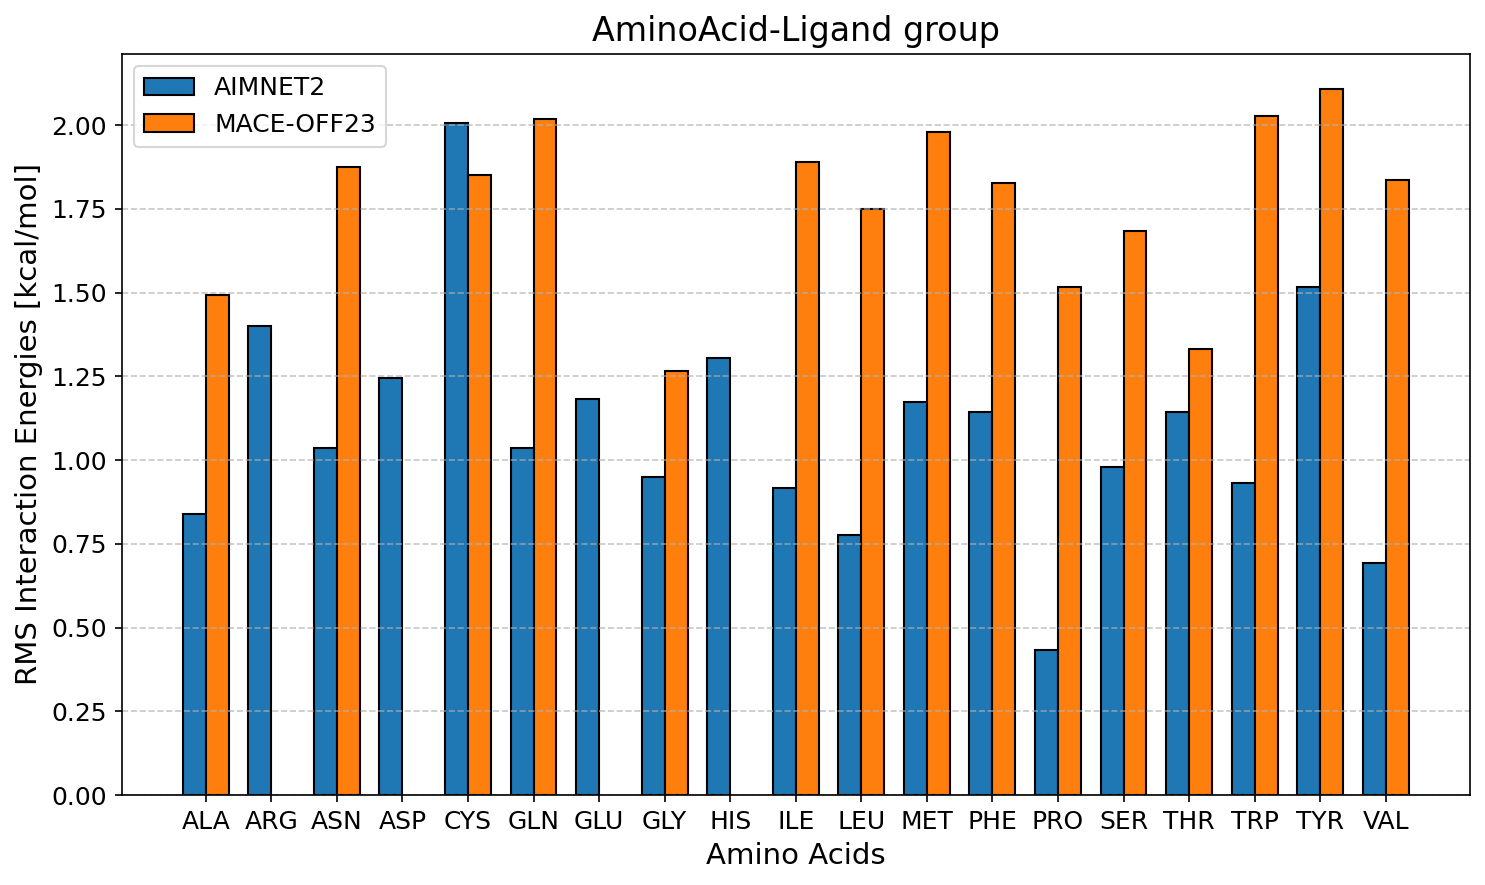

In [208]:
amino_acids = sorted(rmse_aimnet2.keys())

# Convert RMSE values to lists in the same order as amino_acids
rmse_aimnet2_values = [rmse_aimnet2[aa] for aa in amino_acids]
rmse_mace_values = [rmse_mace[aa] for aa in amino_acids]

# Set bar width and positions
bar_width = 0.35  # Width of the bars
x = np.arange(len(amino_acids))  # X locations for the groups

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for AIMNET2 and MACE
bars1 = ax.bar(x - bar_width/2, rmse_aimnet2_values, bar_width, label='AIMNET2(B97-3c)', color=aimnet2_color,edgecolor='black')
bars2 = ax.bar(x + bar_width/2, rmse_mace_values, bar_width, label='MACE-OFF23', color=mace_color,edgecolor='black')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Amino Acids', fontsize=14)
ax.set_ylabel('RMS Interaction Energies [kcal/mol]', fontsize=14)
ax.set_title('AminoAcid-Ligand Group', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(amino_acids, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Adding a legend
ax.legend(fontsize=12)

# Adding a grid for better readability
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)

# Customize the bars with value labels on top
def add_value_labels(bars):
    """Add value labels on top of the bars."""
    for bar in bars:
        height = bar.get_height()

add_value_labels(bars1)
add_value_labels(bars2)

# Tight layout to adjust spacing
fig.tight_layout()

# Show the plot
plt.show()

In [168]:
def compute_E_int(total, aa, lig):
    """Compute interaction energy element-wise, return np.nan for invalid entries."""
    E_int = np.full_like(total, np.nan)
    valid_mask = (~np.isnan(total)) & (~np.isnan(aa)) & (~np.isnan(lig)) & (total != 0) & (aa != 0) & (lig != 0)
    E_int[valid_mask] = (total[valid_mask] - (aa[valid_mask] + lig[valid_mask])) * hartree2ev * ev2kcalmol
    return E_int

total=[np.nan,0,3,5]
aa= [3,4,1,1]
lig= [3,4,np.nan,3]
total=np.array(total)
aa=np.array(aa)
lig=np.array(lig)

B97 =(compute_E_int(total,aa,lig))


In [162]:
total_b97

array([             nan, -1861.3988813312])

In [163]:
aa_b97

array([            nan, -495.6188988481])

In [159]:
save_xyz_file_complex(total_conf[0],number_orca,"0CN_ALA0.xyz")
save_xyz_file(coord_orca_aa[0],number_orca_aa,"0CN_ALA0_aa.xyz")
save_xyz_file(coord_orca_lig[0],number_orca_lig,"0CN_ALA0_lig.xyz")